# Learning analysis

In [1]:
import os
import chess
import pandas as pd
import pickle
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from collections import defaultdict
from scipy import stats
from datetime import datetime
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit

In [2]:
# Increase font size a bit
plt.rcParams.update({'font.size': 16})

## Function definitions

In [3]:
def get_ordered_unique_values(a):
    x,c = np.unique(a,return_counts=True)
    x = x[np.argsort(c)[::-1]]
    c = np.sort(c)[::-1]
    return x,c

In [4]:
def get_mean_and_sem(x):
    return np.nanmean(x),np.nanstd(x)/np.sqrt(len(x))

In [5]:
def exp_func(x, a, b, c):
    return a * np.exp(-b * x) + c

## Queen's Gambit

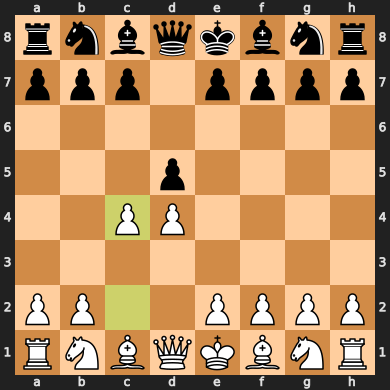

In [6]:
# Visualize the QG
board = chess.Board()
board.push_san('d4')
board.push_san('d5')
board.push_san('c4')
board

In [5]:
# Save out the board image
boardsvg = chess.svg.board(board)
outputfile = open('queens_gambit.svg', "w")
outputfile.write(boardsvg)
outputfile.close()

In [7]:
# Load the csv data of QG games (October 2020 - March 2021)
direc = '../../Data/queens_gambit/'

df = pd.concat([pd.read_csv(direc + 'df_{:d}_{:02d}.csv'.format(2020 + j//12,j%12+1),
                            usecols=['white','black','start_time','fourthmove','rt','result', 'blackelo', 'whiteelo',
                                     'num_black_games','num_white_games'])
                for j in range(9,15)],ignore_index=True)

In [8]:
# Load the pkl data of unique players (March 2020 - September 2020)
players = []
for i in range(3,9):
    with open(direc + 'QG_players_2020_{:02d}.pkl'.format(i),'rb') as f:
        players = pickle.load(f)
s = set(np.array(players).flatten())

# Filter out players who have played the QG in this period
df = df[df['black'].apply(lambda p: not p in s)].reset_index(drop=True)

In [9]:
# Add accept, decline (either the Slav Defense or QG Declined), other to df
df['fourthcode'] = df['fourthmove'].map({'d5c4' : 'A', 'e7e6' : 'D', 'c7c6' : 'D'}).fillna('O')

# Add move index to df
unique_fourthmoves,_ = get_ordered_unique_values(df['fourthmove'].astype(str))
move_to_index = {m:i for i,m in enumerate(unique_fourthmoves)}
df['fourthindex'] = np.array([move_to_index[m] for m in df['fourthmove'].astype(str)])

In [10]:
move_to_index

{'d5c4': 0,
 'e7e6': 1,
 'g8f6': 2,
 'c7c6': 3,
 'b8c6': 4,
 'e7e5': 5,
 'c7c5': 6,
 'c8f5': 7,
 'c8e6': 8,
 'g7g6': 9,
 'b7b6': 10,
 'd8d6': 11,
 'f7f6': 12,
 'f7f5': 13,
 'c8g4': 14,
 'nan': 15,
 'h7h6': 16,
 'a7a6': 17,
 'b8a6': 18,
 'c8d7': 19,
 'b7b5': 20,
 'b8d7': 21,
 'a7a5': 22,
 'h7h5': 23,
 'd8d7': 24,
 'g8h6': 25,
 'g7g5': 26,
 'e8d7': 27,
 'c8h3': 28}

In [11]:
# View the remaining data
df

,white,black,start_time,fourthmove,rt,result,whiteelo,blackelo,num_black_games,num_white_games,fourthcode,fourthindex
0,Future_Star,Jimbobnc,1.601525e+09,c7c5,3.0,1.0,1180,1100,0,0,O,6
1,KhaXIIIled_13,Hosain_alsaadi,1.601525e+09,g8f6,5.0,0.0,1165,1186,0,0,O,2
2,allangargamel,PekeCatriel,1.601526e+09,c7c6,8.0,1.0,1139,993,0,0,D,3
3,FlashGilmore,victorhugocueto,1.601526e+09,c7c6,2.0,1.0,950,872,0,0,D,3
4,codnjk,hatemylife987987,1.601526e+09,g8f6,3.0,1.0,1035,1128,0,0,O,2
...,...,...,...,...,...,...,...,...,...,...,...,...
691232,jruiz10,BySmoot,1.617250e+09,d5c4,-1.0,0.0,1114,1145,0,0,A,0
691233,Sisyfos75,JDG9234,1.617250e+09,d5c4,1.0,1.0,1019,1020,4,0,A,0
691234,BlacKing64,CuzcoMaria17,1.617250e+09,d5c4,2.0,1.0,1102,1040,0,0,A,0
691235,CorporalRivalle,florinarnautu,1.617250e+09,g8f6,1.0,1.0,1174,1195,1,0,O,2


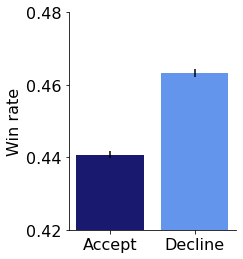

In [12]:
# Plot the overall win rate for accepting/declining the QG
fig, ax = plt.subplots(figsize=(3,4))

df_by_code = df[df['fourthcode'].isin(['A','D'])].groupby('fourthcode')['result'].agg(['mean','sem']).reset_index()
ax.bar(range(len(df_by_code)),1-df_by_code['mean'], color=['midnightblue', 'cornflowerblue'])
ax.errorbar(x=range(len(df_by_code)),y=1-df_by_code['mean'],yerr=df_by_code['sem'],linestyle='None',color='black')
ax.set_xticks(range(len(df_by_code)))
ax.set_xticklabels(['Accept', 'Decline'])
ax.set_yticks([0.42, 0.44, 0.46, 0.48])
ax.set_ylim([0.42,0.48])
ax.set_ylabel('Win rate')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('winrate.png', format='png', dpi=1000,bbox_inches = 'tight')

In [13]:
# Test for significance
accept = [1-df['result'][icurr] for icurr in range(len(df)) if df['fourthcode'][icurr]=='A']
decline = [1-df['result'][icurr] for icurr in range(len(df)) if df['fourthcode'][icurr]=='D']
accept = np.asarray(accept)
decline = np.asarray(decline)
accept = accept[~np.isnan(accept)]
decline = decline[~np.isnan(decline)]

print(st.ttest_ind(accept, decline))

Ttest_indResult(statistic=-15.960573346878302, pvalue=2.488260857119425e-57)


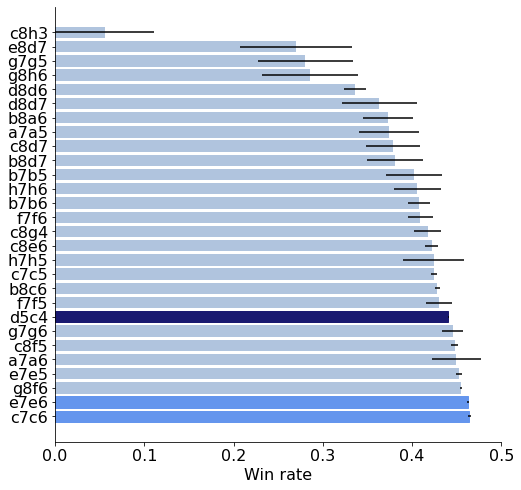

In [14]:
# Plot the win rate for different responses to the QG
fig, ax = plt.subplots(figsize=(8,8))

df_by_move = df.groupby('fourthmove')['result'].agg(['mean','sem']).sort_values('mean').reset_index()
barlist = ax.barh(range(len(df_by_move)),1-df_by_move['mean'], color='lightsteelblue')
ax.errorbar(y=range(len(df_by_move)),x=1-df_by_move['mean'],xerr=df_by_move['sem'],linestyle='None',color='black')
ax.set_yticks(range(len(df_by_move)))
ax.set_yticklabels(labels=df_by_move['fourthmove'])
ax.set_xlabel('Win rate')
ax.set_xlim(0,.5)
ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

barlist[7].set_color('midnightblue')
barlist[0].set_color('cornflowerblue')
barlist[1].set_color('cornflowerblue')

# plt.savefig('responses_winrate.png', format='png', dpi=1000,bbox_inches = 'tight')

In [15]:
# Create a binary dataframe of just accept/decline
df_binary = df[(df['fourthcode'].isin(['A','D'])) & (~df['result'].isna())].reset_index(drop=True)
names,ind = np.unique(df_binary['black'],return_inverse=True)
name_to_ind = dict(zip(names,ind))

df_binary

,white,black,start_time,fourthmove,rt,result,whiteelo,blackelo,num_black_games,num_white_games,fourthcode,fourthindex
0,allangargamel,PekeCatriel,1.601526e+09,c7c6,8.0,1.0,1139,993,0,0,D,3
1,FlashGilmore,victorhugocueto,1.601526e+09,c7c6,2.0,1.0,950,872,0,0,D,3
2,HelloTheSecond,followill8,1.601526e+09,c7c6,6.0,1.0,1054,1091,0,0,D,3
3,ozgurwilly,justben,1.601526e+09,d5c4,-1.0,0.0,968,1128,0,0,A,0
4,bellatrix111,followill8,1.601526e+09,c7c6,3.0,1.0,1060,1078,1,0,D,3
...,...,...,...,...,...,...,...,...,...,...,...,...
480927,blindspott,sartanc,1.617249e+09,d5c4,1.0,0.0,1111,1131,7,0,A,0
480928,jruiz10,BySmoot,1.617250e+09,d5c4,-1.0,0.0,1114,1145,0,0,A,0
480929,Sisyfos75,JDG9234,1.617250e+09,d5c4,1.0,1.0,1019,1020,4,0,A,0
480930,BlacKing64,CuzcoMaria17,1.617250e+09,d5c4,2.0,1.0,1102,1040,0,0,A,0


In [16]:
# Compute the number of unique players that played the opening
len(np.unique(df_binary['black']))

146721

In [17]:
# Compute the percentage of moves that reduction contains
len(df_binary)/len(df)

0.6957555802134434

In [18]:
# Compute the index of the last game as black/white for each QG game
last_game_as_white = [None]*len(df_binary)
last_game_as_black = [None]*len(df_binary)

d_black = defaultdict(lambda: -1)
d_white = defaultdict(lambda: -1)

for i,row in df_binary.iterrows():
    
    last_game_as_white[i] = d_white[row['black']]
    last_game_as_black[i] = d_black[row['black']]
    d_white[row['white']] = i
    d_black[row['black']] = i
    
    if i%100000==0:
        print(i)

0
100000
200000
300000
400000


In [19]:
# Add these to the dataframe
df_binary['last_game_as_white'] = last_game_as_white
df_binary['last_game_as_black'] = last_game_as_black

df_binary

,white,black,start_time,fourthmove,rt,result,whiteelo,blackelo,num_black_games,num_white_games,fourthcode,fourthindex,last_game_as_white,last_game_as_black
0,allangargamel,PekeCatriel,1.601526e+09,c7c6,8.0,1.0,1139,993,0,0,D,3,-1,-1
1,FlashGilmore,victorhugocueto,1.601526e+09,c7c6,2.0,1.0,950,872,0,0,D,3,-1,-1
2,HelloTheSecond,followill8,1.601526e+09,c7c6,6.0,1.0,1054,1091,0,0,D,3,-1,-1
3,ozgurwilly,justben,1.601526e+09,d5c4,-1.0,0.0,968,1128,0,0,A,0,-1,-1
4,bellatrix111,followill8,1.601526e+09,c7c6,3.0,1.0,1060,1078,1,0,D,3,-1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480927,blindspott,sartanc,1.617249e+09,d5c4,1.0,0.0,1111,1131,7,0,A,0,-1,480908
480928,jruiz10,BySmoot,1.617250e+09,d5c4,-1.0,0.0,1114,1145,0,0,A,0,-1,-1
480929,Sisyfos75,JDG9234,1.617250e+09,d5c4,1.0,1.0,1019,1020,4,0,A,0,-1,401683
480930,BlacKing64,CuzcoMaria17,1.617250e+09,d5c4,2.0,1.0,1102,1040,0,0,A,0,-1,-1


In [20]:
# Compute the win-stay, lose-shift mean and sem for the QG
result = df_binary['result'].values
code = df_binary['fourthcode'].values

means = [get_mean_and_sem([code[icurr]==code[iprev] for icurr,iprev in enumerate(df_binary['last_game_as_black']) 
                           if iprev>=0 and result[iprev]==res]) for res in [1,0.5,0]]

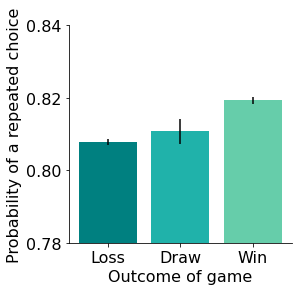

In [21]:
# Plot the win-stay, lose-shift probabilities for the QG
fig, ax = plt.subplots(figsize=(4,4))
colors = ['teal', 'lightseagreen', 'mediumaquamarine']

x = [1,2,3]
ax.bar(x,[m for m,s in means], color=[c for c in colors])
ax.errorbar(x,y=[m for m,s in means],yerr=[s for m,s in means],linestyle='None',color='black')
ax.set_xticks(x)
ax.set_xticklabels(['Loss','Draw','Win'])
ax.set_yticks([0.78,0.8,0.82,0.84])
ax.set_ylim([0.78,0.84])
ax.set_ylabel('Probability of a repeated choice')
ax.set_xlabel('Outcome of game')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('RL_repeat.png', format='png', dpi=1000,bbox_inches = 'tight')

In [22]:
# Test for significance
loss = [code[icurr]==code[iprev] for icurr,iprev in enumerate(df_binary['last_game_as_black']) 
                           if iprev>=0 and result[iprev]==1]
win = [code[icurr]==code[iprev] for icurr,iprev in enumerate(df_binary['last_game_as_black']) 
                           if iprev>=0 and result[iprev]==0]

print(st.ttest_ind(loss, win))

Ttest_indResult(statistic=-8.308053504833246, pvalue=9.765698185733581e-17)


In [23]:
# Repeat for the opponent's move
result = df_binary['result'].values
code = df_binary['fourthcode'].values

means = [get_mean_and_sem([code[icurr]==code[iprev] for icurr,iprev in enumerate(df_binary['last_game_as_white']) 
                           if iprev>=0 and result[iprev]==res]) for res in [0,0.5,1]]

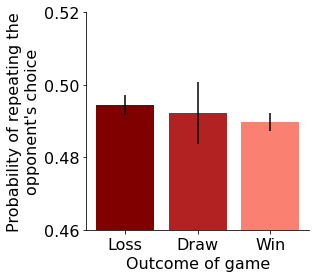

In [24]:
# Plot
fig, ax = plt.subplots(figsize=(4,4))
colors = ['maroon', 'firebrick', 'salmon']

x = [1,2,3]
ax.bar(x,[m for m,s in means], color=[c for c in colors])
ax.errorbar(x,y=[m for m,s in means],yerr=[s for m,s in means],linestyle='None',color='black')
ax.set_xticks(x)
ax.set_xticklabels(['Loss','Draw','Win'])
ax.set_yticks([0.46,0.48,0.5,.52])
ax.set_ylim([0.46,0.52])
ax.set_ylabel('Probability of repeating the\nopponent\'s choice')
ax.set_xlabel('Outcome of game')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('opp_RL_repeat.png', format='png', dpi=1000,bbox_inches = 'tight')

In [25]:
# Test for significance
loss = [code[icurr]==code[iprev] for icurr,iprev in enumerate(df_binary['last_game_as_white']) 
                           if iprev>=0 and result[iprev]==0]
win = [code[icurr]==code[iprev] for icurr,iprev in enumerate(df_binary['last_game_as_white']) 
                           if iprev>=0 and result[iprev]==1]

print(st.ttest_ind(loss, win))

Ttest_indResult(statistic=1.2563575949739607, pvalue=0.20899046513843403)


In [26]:
# Repeat for copy effect
result = df_binary['result'].values
code = df_binary['fourthcode'].values

means = [get_mean_and_sem([code[icurr]=='D' for icurr,iprev in enumerate(df_binary['last_game_as_white']) 
                           if iprev>=0 and code[iprev]==opp_code]) for opp_code in ['A','D']]

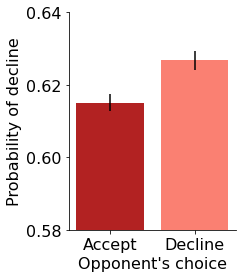

In [27]:
# Plot
fig, ax = plt.subplots(figsize=(3,4))
colors = ['firebrick', 'salmon']

x = [1,2]
ax.bar(x,[m for m,s in means], color=[c for c in colors])
ax.errorbar(x,y=[m for m,s in means],yerr=[s for m,s in means],linestyle='None',color='black')
ax.set_xticks(x)
ax.set_xticklabels(['Accept','Decline'])
ax.set_yticks([0.58,0.6,0.62,.64])
ax.set_ylim([0.58,0.64])
ax.set_ylabel('Probability of decline')
ax.set_xlabel('Opponent\'s choice')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('opp_copy.png', format='png', dpi=1000,bbox_inches = 'tight')

In [28]:
# Test for significance
accept = [code[icurr]=='D' for icurr,iprev in enumerate(df_binary['last_game_as_white']) 
                           if iprev>=0 and code[iprev]=='A']
decline = [code[icurr]=='D' for icurr,iprev in enumerate(df_binary['last_game_as_white']) 
                           if iprev>=0 and code[iprev]=='D']

print(st.ttest_ind(accept, decline))

Ttest_indResult(statistic=-3.269518303139598, pvalue=0.001077794263556572)


In [29]:
# Compute the index of the nth QG game back as black
nback = last_game_as_black
for n in range(1,31):
    df_binary['black_game_' + str(n) + '_back'] = nback
    nback = [last_game_as_black[i] if i>=0 else -1 for i in nback]

In [30]:
df_binary

,white,black,start_time,fourthmove,rt,result,whiteelo,blackelo,num_black_games,num_white_games,...,black_game_21_back,black_game_22_back,black_game_23_back,black_game_24_back,black_game_25_back,black_game_26_back,black_game_27_back,black_game_28_back,black_game_29_back,black_game_30_back
0,allangargamel,PekeCatriel,1.601526e+09,c7c6,8.0,1.0,1139,993,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,FlashGilmore,victorhugocueto,1.601526e+09,c7c6,2.0,1.0,950,872,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,HelloTheSecond,followill8,1.601526e+09,c7c6,6.0,1.0,1054,1091,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,ozgurwilly,justben,1.601526e+09,d5c4,-1.0,0.0,968,1128,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,bellatrix111,followill8,1.601526e+09,c7c6,3.0,1.0,1060,1078,1,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480927,blindspott,sartanc,1.617249e+09,d5c4,1.0,0.0,1111,1131,7,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
480928,jruiz10,BySmoot,1.617250e+09,d5c4,-1.0,0.0,1114,1145,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
480929,Sisyfos75,JDG9234,1.617250e+09,d5c4,1.0,1.0,1019,1020,4,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
480930,BlacKing64,CuzcoMaria17,1.617250e+09,d5c4,2.0,1.0,1102,1040,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [33]:
# Compute the win-stay, lose-shift mean and sem for the QG 2 games back
rl_probs = np.zeros((4,4))
rl_count = np.zeros((4,4))
rl_vals = [[] for x in range(16)]

result = df_binary['result'].values
code = df_binary['fourthcode'].values

# Loop through the dataframe
for ind in df_binary.index:
    
    # Grab the previous 2 indices, results, and codes as black
    res = df_binary['result'][ind]
    iprev1 = df_binary['black_game_1_back'][ind]
    iprev2 = df_binary['black_game_2_back'][ind]
    res1 = result[iprev1]
    res2 = result[iprev2]
    code1 = code[iprev1]
    code2 = code[iprev2]
    
    # If there is a 2 game history
    if iprev1 >= 0 and iprev2 >= 0:
        
        # Check if there was a repetition
        if code[ind] == code1:
            repeat = 1
        else:
            repeat = 0
        
        # Assign it to the correct part of the array
        if code2 == 'A' and res2 == 1 and code1 == 'A' and res1 == 1:
            rl_vals[0].append(repeat)
        elif code2 == 'A' and res2 == 1 and code1 == 'A' and res1 == 0:
            rl_vals[1].append(repeat)
        elif code2 == 'A' and res2 == 1 and code1 == 'D' and res1 == 1:
            rl_vals[2].append(repeat)
        elif code2 == 'A' and res2 == 1 and code1 == 'D' and res1 == 0:
            rl_vals[3].append(repeat)
            
        elif code2 == 'A' and res2 == 0 and code1 == 'A' and res1 == 1:
            rl_vals[4].append(repeat)
        elif code2 == 'A' and res2 == 0 and code1 == 'A' and res1 == 0:
            rl_vals[5].append(repeat)
        elif code2 == 'A' and res2 == 0 and code1 == 'D' and res1 == 1:
            rl_vals[6].append(repeat)
        elif code2 == 'A' and res2 == 0 and code1 == 'D' and res1 == 0:
            rl_vals[7].append(repeat)
            
        elif code2 == 'D' and res2 == 1 and code1 == 'A' and res1 == 1:
            rl_vals[8].append(repeat)
        elif code2 == 'D' and res2 == 1 and code1 == 'A' and res1 == 0:
            rl_vals[9].append(repeat)
        elif code2 == 'D' and res2 == 1 and code1 == 'D' and res1 == 1:
            rl_vals[10].append(repeat)
        elif code2 == 'D' and res2 == 1 and code1 == 'D' and res1 == 0:
            rl_vals[11].append(repeat)
            
        elif code2 == 'D' and res2 == 0 and code1 == 'A' and res1 == 1:
            rl_vals[12].append(repeat)
        elif code2 == 'D' and res2 == 0 and code1 == 'A' and res1 == 0:
            rl_vals[13].append(repeat)
        elif code2 == 'D' and res2 == 0 and code1 == 'D' and res1 == 1:
            rl_vals[14].append(repeat)
        elif code2 == 'D' and res2 == 0 and code1 == 'D' and res1 == 0:
            rl_vals[15].append(repeat)


In [34]:
# Compute all combinations of the probabilities
means = []
sems = []

for i in range(16):
    means.append(np.mean(rl_vals[i]))
    sems.append(stats.sem(rl_vals[i]))
    
means

[0.8856052313996239,
 0.8903989631861011,
 0.519009989563143,
 0.5499486828600753,
 0.8861797199352615,
 0.8928835369299657,
 0.5367500993245927,
 0.5321487023614683,
 0.5892199017199017,
 0.6170171715222844,
 0.8643335684062059,
 0.874031982299105,
 0.5843785632839225,
 0.5991022915190173,
 0.8681607106803957,
 0.8779313818772038]

In [35]:
# Generate a colormap
data = [i for i in range(18)]
denominator = max(data) - min(data)
scaled_data = [(datum-min(data))/denominator for datum in data]
colors = []
cmap = plt.cm.get_cmap('Greens_r')
for decimal in scaled_data:
    colors.append(cmap(decimal))

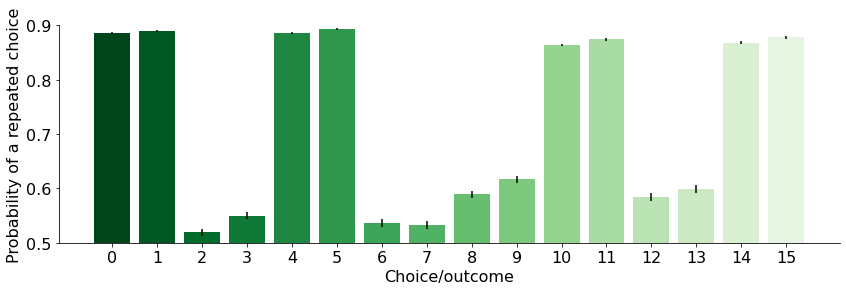

In [36]:
# Plot
fig, ax = plt.subplots(figsize=(14,4))
ax.bar(np.arange(16), means, color=colors)
ax.errorbar(np.arange(16), means,yerr=sems,linestyle='None',color='black')
ax.set_xticks(np.arange(16))
ax.set_ylim([0.5,0.9])
ax.set_ylabel('Probability of a repeated choice')
ax.set_xlabel('Choice/outcome')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('RL_tree.png', format='png', dpi=1000,bbox_inches = 'tight')

In [38]:
# Test for significance (stay vs. shift with same outcomes and initial choice)
print(st.ttest_ind(rl_vals[0], rl_vals[2]))
print(st.ttest_ind(rl_vals[1], rl_vals[3]))
print(st.ttest_ind(rl_vals[4], rl_vals[6]))
print(st.ttest_ind(rl_vals[5], rl_vals[7]))
print(st.ttest_ind(rl_vals[8], rl_vals[10]))
print(st.ttest_ind(rl_vals[9], rl_vals[11]))
print(st.ttest_ind(rl_vals[12], rl_vals[14]))
print(st.ttest_ind(rl_vals[13], rl_vals[15]))

Ttest_indResult(statistic=77.95987531993777, pvalue=0.0)
Ttest_indResult(statistic=67.59944934352313, pvalue=0.0)
Ttest_indResult(statistic=65.12706578525163, pvalue=0.0)
Ttest_indResult(statistic=62.618036380975354, pvalue=0.0)
Ttest_indResult(statistic=-51.374166383208376, pvalue=0.0)
Ttest_indResult(statistic=-44.65383999380421, pvalue=0.0)
Ttest_indResult(statistic=-48.658427635133414, pvalue=0.0)
Ttest_indResult(statistic=-44.78447758181402, pvalue=0.0)


In [37]:
# Test for significance (loss vs. win on last game)
print(st.ttest_ind(rl_vals[0], rl_vals[1]))
print(st.ttest_ind(rl_vals[2], rl_vals[3]))
print(st.ttest_ind(rl_vals[4], rl_vals[5]))
print(st.ttest_ind(rl_vals[6], rl_vals[7]))
print(st.ttest_ind(rl_vals[8], rl_vals[9]))
print(st.ttest_ind(rl_vals[10], rl_vals[11]))
print(st.ttest_ind(rl_vals[12], rl_vals[13]))
print(st.ttest_ind(rl_vals[14], rl_vals[15]))

Ttest_indResult(statistic=-1.9117428855238643, pvalue=0.055913629109205616)
Ttest_indResult(statistic=-3.4673466291450667, pvalue=0.0005273843600485574)
Ttest_indResult(statistic=-2.4080414749600427, pvalue=0.016041855608745142)
Ttest_indResult(statistic=0.44355782585136877, pvalue=0.6573726115318352)
Ttest_indResult(statistic=-3.051130066738546, pvalue=0.002284927708876785)
Ttest_indResult(statistic=-2.957994353154154, pvalue=0.0030981794489083154)
Ttest_indResult(statistic=-1.4504657008537543, pvalue=0.1469617363781917)
Ttest_indResult(statistic=-2.8424304937781235, pvalue=0.004479504617977755)


In [39]:
# Create an array with the outcomes of the previous games
X = np.array([[0.5 if iprev==-1 else 
               (df_binary['result'][iprev] if df_binary['fourthcode'][iprev]=='D' else 1-df_binary['result'][iprev]) 
               for iprev in df_binary['black_game_' + str(n) + '_back']] for n in range(1,31)])

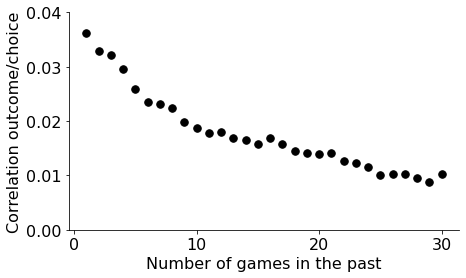

In [40]:
# Plot the correlation between outcome of previous games and choice to accept in current game
fig, ax = plt.subplots(figsize=(7,4))

ax.plot(range(1,31),[np.corrcoef(X[n,:],df_binary['fourthcode']=='D')[0,1] for n in range(30)],'.',markersize=15, color='black')
ax.set_xlabel('Number of games in the past')
ax.set_ylabel('Correlation outcome/choice')
ax.set_yticks(np.arange(0,1,0.01))
ax.set_xticks([0,10,20,30])
ax.set_ylim([0,0.04])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('RL_corr.png', format='png', dpi=1000,bbox_inches = 'tight')

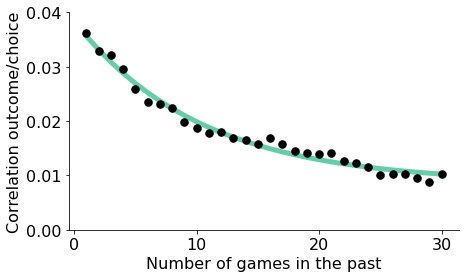

In [41]:
# Same plot with an exponential fit
popt, pcov = curve_fit(exp_func, range(1,31), [np.corrcoef(X[n,:],df_binary['fourthcode']=='D')[0,1] for n in range(30)])

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(range(1,31), exp_func(range(1,31), *popt), lw=5, color='mediumaquamarine')
ax.plot(range(1,31),[np.corrcoef(X[n,:],df_binary['fourthcode']=='D')[0,1] for n in range(30)],'.',markersize=15, color='black')
ax.set_xlabel('Number of games in the past')
ax.set_ylabel('Correlation outcome/choice')
ax.set_yticks(np.arange(0,1,0.01))
ax.set_xticks([0,10,20,30])
ax.set_ylim([0,0.04])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('RL_corr.png', format='png', dpi=1000,bbox_inches = 'tight')

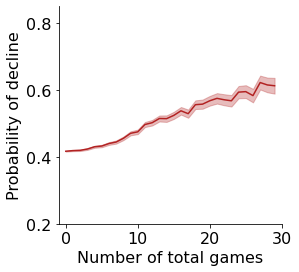

In [42]:
# Plot the probability of choices depending on the number of previous QG games (irrespective of color)
fig, ax = plt.subplots(figsize=(4,4))

n_games = 30
code = 'D'
m = np.array([get_mean_and_sem(df_binary[(df_binary['num_black_games'] + df_binary['num_white_games'])==i]['fourthcode']==code) for i in range(n_games)])
ax.plot(m[:,0], color='firebrick')
ax.fill_between(range(n_games), m[:,0]-m[:,1],m[:,0]+m[:,1], alpha=0.3, color='firebrick')
    
ax.set_xlabel('Number of total games')
ax.set_ylabel('Probability of decline')
ax.set_xticks([0, 10, 20, 30])
ax.set_yticks([.2, .4, .6, .8])
ax.set_xlim(-1,n_games)
ax.set_ylim(0.2,0.85)
# ax.legend(bbox_to_anchor=(1,1), frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('prob_all.png', format='png', dpi=1000,bbox_inches = 'tight')

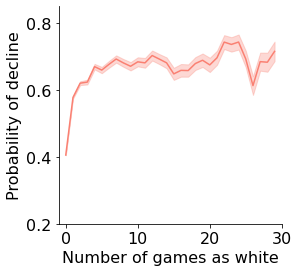

In [43]:
# Plot the probability of choices depending on the number of previous white QG games
fig, ax = plt.subplots(figsize=(4,4))

m = np.array([get_mean_and_sem(df_binary[df_binary['num_white_games']==i]['fourthcode']==code) for i in range(n_games)])
ax.plot(m[:,0], color='salmon')
ax.fill_between(range(n_games),m[:,0]-m[:,1],m[:,0]+m[:,1], alpha=0.3, color='salmon')
    
ax.set_xlabel('Number of games as white')
ax.set_ylabel('Probability of decline')
ax.set_xticks([0, 10, 20, 30])
ax.set_yticks([.2, .4, .6, .8])
ax.set_xlim(-1,n_games)
ax.set_ylim(0.2,0.85)
# ax.legend(bbox_to_anchor=(1,1), frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('prob_white.png', format='png', dpi=1000,bbox_inches = 'tight')

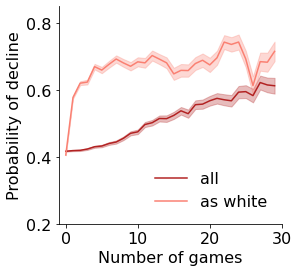

In [44]:
# Plot the probability of choices depending on the number of previous total + white QG games
fig, ax = plt.subplots(figsize=(4,4))

m = np.array([get_mean_and_sem(df_binary[(df_binary['num_black_games'] + df_binary['num_white_games'])==i]['fourthcode']==code) for i in range(n_games)])
ax.plot(m[:,0], color='firebrick', label='all')
ax.fill_between(range(n_games), m[:,0]-m[:,1],m[:,0]+m[:,1], alpha=0.3, color='firebrick')

m = np.array([get_mean_and_sem(df_binary[df_binary['num_white_games']==i]['fourthcode']==code) for i in range(n_games)])
ax.plot(m[:,0], color='salmon', label='as white')
ax.fill_between(range(n_games),m[:,0]-m[:,1],m[:,0]+m[:,1], alpha=0.3, color='salmon')
    
ax.set_xlabel('Number of games')
ax.set_ylabel('Probability of decline')
ax.set_xticks([0, 10, 20, 30])
ax.set_yticks([.2, .4, .6, .8])
ax.set_xlim(-1,n_games)
ax.set_ylim(0.2,0.85)
ax.legend(loc='lower right', frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('prob_split.png', format='png', dpi=1000,bbox_inches = 'tight')

In [45]:
# Compute the mean and sem binned for response time vs. probability of decline
all_rt = df_binary.loc[df_binary['rt'] >= 0]['rt'].values
all_codes = df_binary.loc[df_binary['rt'] >= 0]['fourthcode'].values
all_codes_binary = np.where(all_codes == 'D', 1, 0)

bin_means, bin_edges, binnumber = binned_statistic(all_rt, all_codes_binary, statistic='mean', bins=10, range=(0, 10))
bin_sem, bin_edges_sem, binnumber_sem = binned_statistic(all_rt, all_codes_binary, statistic=stats.sem, bins=10, range=(0, 10))

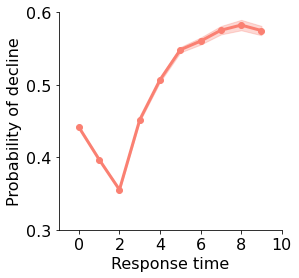

In [46]:
# Plot
fig, ax = plt.subplots(figsize=(4,4))

ax.errorbar(bin_edges[:-1], bin_means, marker='o', color='salmon', lw=3)
ax.fill_between(bin_edges[:-1], bin_means-bin_sem, bin_means+bin_sem, color='salmon', alpha=0.3)
ax.set_ylabel('Probability of decline')
ax.set_xlabel('Response time')
ax.set_xlim(-1, 10)
ax.set_ylim(0.3,0.6)
ax.set_xticks([0, 2, 4, 6, 8, 10])
ax.set_yticks([0.3, 0.4, 0.5, 0.6])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('rt_decline.png', format='png', dpi=1000,bbox_inches = 'tight')

In [47]:
# Compute the mean and sem binned for elo rating vs. probability of decline
all_elo = df_binary.loc[df_binary['blackelo'] >= 0]['blackelo'].values
all_codes = df_binary.loc[df_binary['blackelo'] >= 0]['fourthcode'].values
all_codes_binary = np.where(all_codes == 'D', 1, 0)

bin_means, bin_edges, binnumber = binned_statistic(all_elo, all_codes_binary, statistic='mean', bins=10, range=(800, 1200))
bin_sem, bin_edges_sem, binnumber_sem = binned_statistic(all_elo, all_codes_binary, statistic=stats.sem, bins=10, range=(800, 1200))

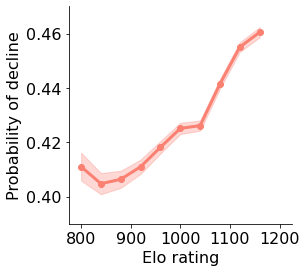

In [48]:
# Plot
fig, ax = plt.subplots(figsize=(4,4))

ax.errorbar(bin_edges[:-1], bin_means, marker='o', color='salmon', lw=3)
ax.fill_between(bin_edges[:-1], bin_means-bin_sem, bin_means+bin_sem, color='salmon', alpha=0.3)
ax.set_ylabel('Probability of decline')
ax.set_xlabel('Elo rating')
ax.set_xlim(775, 1225)
ax.set_ylim(0.39,0.47)
ax.set_xticks([800, 900, 1000, 1100, 1200])
ax.set_yticks([0.4, .42, .44, .46])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('elo_decline.png', format='png', dpi=1000,bbox_inches = 'tight')

In [49]:
# Compute the correlation between player and opponent elo
print(df_binary['blackelo'].corr(df_binary['whiteelo']))

0.7962053960920727


Text(0, 0.5, 'Number of games')

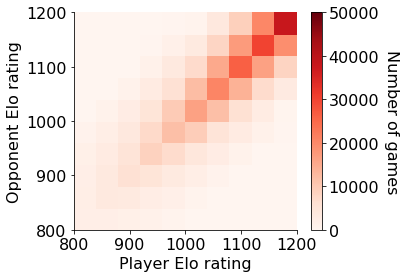

In [50]:
player_elo = df_binary['blackelo'].values
opp_elo = df_binary['whiteelo'].values

# Plot
fig, ax = plt.subplots(figsize=(5,4))

counts, xedges, yedges, im = ax.hist2d(player_elo, opp_elo, cmap=plt.cm.Reds, vmin=0, vmax=50000)
ax.set_ylabel('Opponent Elo rating')
ax.set_xlabel('Player Elo rating')
ax.set_xticks([800, 900, 1000, 1100, 1200])
ax.set_yticks([800, 900, 1000, 1100, 1200])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Number of games', rotation=-90, labelpad=20)

# plt.savefig('elo_corr.png', format='png', dpi=1000,bbox_inches = 'tight')

In [51]:
# Loop through the dataframe and compute time gap from last game as black/white
gap_black = []
gap_white = []

for ind in df_binary.index:
    
    # Grab the previous indices
    iprev_black = df_binary['last_game_as_black'][ind]
    iprev_white = df_binary['last_game_as_white'][ind]
    
    # Compute the time difference in seconds
    if iprev_black >= 0:
        curr_time = df_binary['start_time'][ind]
        prev_time = df_binary['start_time'][iprev_black]
        gap_black.append(curr_time-prev_time)
        
    else:
        gap_black.append(-1)
        
    if iprev_white >= 0:
        curr_time = df_binary['start_time'][ind]
        prev_time = df_binary['start_time'][iprev_white]
        gap_white.append(curr_time-prev_time)
        
    else:
        gap_white.append(-1)

In [52]:
# Add the time gap to the dataframe
df_binary['gap_black'] = gap_black
df_binary['gap_white'] = gap_white

In [53]:
df_binary

,white,black,start_time,fourthmove,rt,result,whiteelo,blackelo,num_black_games,num_white_games,...,black_game_23_back,black_game_24_back,black_game_25_back,black_game_26_back,black_game_27_back,black_game_28_back,black_game_29_back,black_game_30_back,gap_black,gap_white
0,allangargamel,PekeCatriel,1.601526e+09,c7c6,8.0,1.0,1139,993,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1.0,-1.0
1,FlashGilmore,victorhugocueto,1.601526e+09,c7c6,2.0,1.0,950,872,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1.0,-1.0
2,HelloTheSecond,followill8,1.601526e+09,c7c6,6.0,1.0,1054,1091,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1.0,-1.0
3,ozgurwilly,justben,1.601526e+09,d5c4,-1.0,0.0,968,1128,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1.0,-1.0
4,bellatrix111,followill8,1.601526e+09,c7c6,3.0,1.0,1060,1078,1,0,...,-1,-1,-1,-1,-1,-1,-1,-1,495.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480927,blindspott,sartanc,1.617249e+09,d5c4,1.0,0.0,1111,1131,7,0,...,-1,-1,-1,-1,-1,-1,-1,-1,835.0,-1.0
480928,jruiz10,BySmoot,1.617250e+09,d5c4,-1.0,0.0,1114,1145,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1.0,-1.0
480929,Sisyfos75,JDG9234,1.617250e+09,d5c4,1.0,1.0,1019,1020,4,0,...,-1,-1,-1,-1,-1,-1,-1,-1,1993600.0,-1.0
480930,BlacKing64,CuzcoMaria17,1.617250e+09,d5c4,2.0,1.0,1102,1040,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1.0,-1.0


In [54]:
# Compute the gap irrespective of color
time = []
time_codes = []

for ind in df_binary.index:
    
    gap_black = df_binary['gap_black'][ind]
    gap_white = df_binary['gap_white'][ind]
    min_time = min(gap_black, gap_white)
    max_time = max(gap_black, gap_white)
    
    if min_time >= 0:
        time.append(min_time)
        time_codes.append(df_binary['fourthcode'][ind])
    elif max_time >= 0:
        time.append(max_time)
        time_codes.append(df_binary['fourthcode'][ind])        

In [55]:
# Compute the mean and sem binned for gap vs. probability of decline
time_codes_binary = np.where(np.asarray(time_codes) == 'D', 1, 0)

bin_means, bin_edges, binnumber = binned_statistic(np.asarray(time)/(60*60*24), time_codes_binary, statistic='mean', bins=10, range=(0, 20))
bin_sem, bin_edges_sem, binnumber_sem = binned_statistic(np.asarray(time)/(60*60*24), time_codes_binary, statistic=stats.sem, bins=10, range=(0, 20))

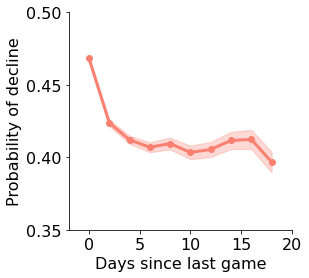

In [56]:
fig, ax = plt.subplots(figsize=(4,4))

ax.errorbar(bin_edges[:-1], bin_means, marker='o', color='salmon', lw=3)
ax.fill_between(bin_edges[:-1], bin_means-bin_sem, bin_means+bin_sem, color='salmon', alpha=0.3)
ax.set_ylabel('Probability of decline')
ax.set_xlabel('Days since last game')
ax.set_xlim(-2, 20)
ax.set_ylim(0.35,0.5)
ax.set_xticks([0, 5, 10, 15, 20])
ax.set_yticks([0.35, 0.4, .45, 0.5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('time_decline.png', format='png', dpi=1000,bbox_inches = 'tight')

In [57]:
# Loop through the dataframe and compute if there was a shift in choice
shift = []

for ind in df_binary.index:
    
    # Grab the previous index and current choice
    iprev_black = df_binary['last_game_as_black'][ind]
    curr_choice = df_binary['fourthcode'][ind]
    
    # Compute the shift
    if iprev_black >= 0:
        prev_choice = df_binary['fourthcode'][iprev_black]
        if prev_choice == curr_choice:
            shift.append(0)
        else:
            shift.append(1)
    else:
        shift.append(-1)

In [58]:
# Add the shift to the dataframe
df_binary['shift'] = shift

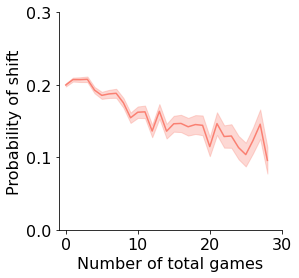

In [59]:
# Plot the probability of changing a shift depending on the number of previous QG games (irrespective of color)
fig, ax = plt.subplots(figsize=(4,4))

m = np.array([get_mean_and_sem(df_binary[((df_binary['num_black_games'] + df_binary['num_white_games'])==i) & (df_binary['fourthcode']==code)]['shift']==1) for i in range(n_games)])
ax.plot(m[1:,0], color='salmon')
ax.fill_between(range(n_games-1),m[1:,0]-m[1:,1],m[1:,0]+m[1:,1], alpha=0.3, color='salmon')
    
ax.set_xlabel('Number of total games')
ax.set_ylabel('Probability of shift')
ax.set_xticks([0, 10, 20, 30])
ax.set_yticks([0, .1, .2, .3])
ax.set_xlim(-1,n_games)
ax.set_ylim(0,0.3)
# ax.legend(bbox_to_anchor=(1,1), frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('prob_shift.png', format='png', dpi=1000,bbox_inches = 'tight')

## Sicilian Defense

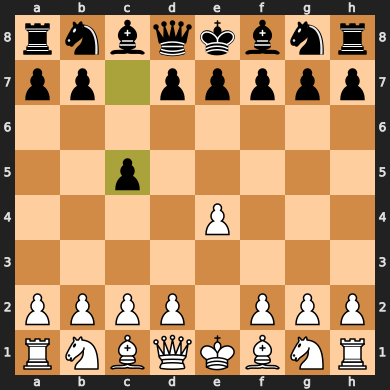

In [7]:
# Visualize the Sicilian Defense
board = chess.Board()
board.push_san('e4')
board.push_san('c5')
board

In [40]:
# Save out the board image
boardsvg = chess.svg.board(board)
outputfile = open('sicilian_defense.svg', "w")
outputfile.write(boardsvg)
outputfile.close()

In [61]:
# Load the csv data of SD games (October 2020 - March 2021)
direc = '../../Data/sicilian_defense/'

df = pd.concat([pd.read_csv(direc + 'df_{:d}_{:02d}.csv'.format(2020 + j//12,j%12+1),
                            usecols=['white','black','start_time','thirdmove','rt','result', 'blackelo', 'whiteelo',
                                     'num_black_games','num_white_games'])
                for j in range(9,15)],ignore_index=True)

In [62]:
# Load the pkl data of unique players (March 2020 - September 2020)
players = []
for i in range(3,9):
    with open(direc + 'SD_players_2020_{:02d}.pkl'.format(i),'rb') as f:
        players = pickle.load(f)
s = set(np.array(players).flatten())

# Filter out players who have played the SD in this period
df = df[df['white'].apply(lambda p: not p in s)].reset_index(drop=True)

In [63]:
# Add closed, open, or else to df
df['thirdcode'] = df['thirdmove'].map({'b1c3' : 'C', 'g1f3' : 'O'}).fillna('E')

# Add move index to df
unique_thirdmoves,_ = get_ordered_unique_values(df['thirdmove'].astype(str))
move_to_index = {m:i for i,m in enumerate(unique_thirdmoves)}
df['thirdindex'] = np.array([move_to_index[m] for m in df['thirdmove'].astype(str)])

In [64]:
move_to_index

{'g1f3': 0,
 'f1c4': 1,
 'd2d4': 2,
 'b1c3': 3,
 'd1h5': 4,
 'd2d3': 5,
 'c2c3': 6,
 'c2c4': 7,
 'f2f4': 8,
 'd1f3': 9,
 'e4e5': 10,
 'b2b3': 11,
 'f1b5': 12,
 'f2f3': 13,
 'g2g3': 14,
 'a2a3': 15,
 'nan': 16,
 'b2b4': 17,
 'f1d3': 18,
 'g1h3': 19,
 'b1a3': 20,
 'd1g4': 21,
 'g1e2': 22,
 'd1e2': 23,
 'f1e2': 24,
 'g2g4': 25,
 'a2a4': 26,
 'h2h3': 27,
 'h2h4': 28,
 'e1e2': 29,
 'f1a6': 30}

In [65]:
# View the remaining data
df

,black,white,start_time,thirdmove,rt,result,blackelo,whiteelo,num_black_games,num_white_games,thirdcode,thirdindex
0,Kami_of_Honmaru,wonderingblunder,1.601525e+09,b1c3,4.0,1.0,1194,1121,0,0,C,3
1,jy3,Scratchman,1.601525e+09,g1f3,1.0,0.0,1073,1194,0,0,O,0
2,spitecheck,zralybokyma,1.601525e+09,f1b5,13.0,0.0,882,809,0,0,E,12
3,dermaxe,Pandi9595,1.601525e+09,b1c3,2.0,1.0,1036,1134,0,0,C,3
4,duliomarcio,Raptorax,1.601525e+09,g1f3,-1.0,0.0,1145,1158,0,0,O,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1406939,DawsonRicardo,aruniyer88,1.617250e+09,g1f3,2.0,1.0,1024,1005,12,0,O,0
1406940,Greyuta,Moi555,1.617250e+09,a2a3,2.0,0.0,1034,1049,6,0,E,15
1406941,Powder36,phildeacon,1.617250e+09,d1h5,4.0,0.0,1115,1123,14,0,E,4
1406942,Arteaga1811,Kh0nsu,1.617250e+09,g1f3,5.0,1.0,916,851,1,1,O,0


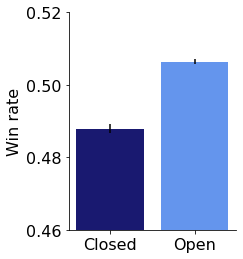

In [66]:
# Plot the overall win rate for closed/open SD
fig, ax = plt.subplots(figsize=(3,4))

df_by_code = df[df['thirdcode'].isin(['C','O'])].groupby('thirdcode')['result'].agg(['mean','sem']).reset_index()
ax.bar(range(len(df_by_code)),df_by_code['mean'], color=['midnightblue', 'cornflowerblue'])
ax.errorbar(x=range(len(df_by_code)),y=df_by_code['mean'],yerr=df_by_code['sem'],linestyle='None',color='black')
ax.set_xticks(range(len(df_by_code)))
ax.set_xticklabels(['Closed', 'Open'])
ax.set_yticks([0.46, 0.48, 0.5, 0.52])
ax.set_ylim([0.46,0.52])
ax.set_ylabel('Win rate')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('winrate.png', format='png', dpi=1000,bbox_inches = 'tight')

In [67]:
# Test for significance
closed = [df['result'][icurr] for icurr in range(len(df)) if df['thirdcode'][icurr]=='C']
opensd = [df['result'][icurr] for icurr in range(len(df)) if df['thirdcode'][icurr]=='O']
closed = np.asarray(closed)
opensd = np.asarray(opensd)
closed = closed[~np.isnan(closed)]
opensd = opensd[~np.isnan(opensd)]

print(st.ttest_ind(closed, opensd))

Ttest_indResult(statistic=-12.675945755225309, pvalue=8.112198318739403e-37)


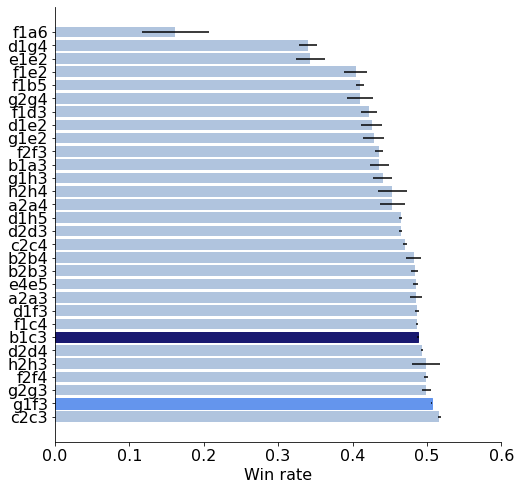

In [68]:
# Plot the win rate for different responses to the SD
fig, ax = plt.subplots(figsize=(8,8))

df_by_move = df.groupby('thirdmove')['result'].agg(['mean','sem']).sort_values('mean').reset_index()
barlist = ax.barh(range(len(df_by_move)),df_by_move['mean'], color='lightsteelblue')
ax.errorbar(y=range(len(df_by_move)),x=df_by_move['mean'],xerr=df_by_move['sem'],linestyle='None',color='black')
ax.set_yticks(range(len(df_by_move)))
ax.set_yticklabels(labels=df_by_move['thirdmove'])
ax.set_xlabel('Win rate')
ax.set_xlim(0,.56)
ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5,0.6])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

barlist[23].set_color('midnightblue')
barlist[28].set_color('cornflowerblue')
plt.gca().invert_yaxis()

# plt.savefig('responses_winrate.png', format='png', dpi=1000,bbox_inches = 'tight')

In [69]:
# Create a binary dataframe of just closed/open
df_binary = df[(df['thirdcode'].isin(['C','O'])) & (~df['result'].isna())].reset_index(drop=True)
names,ind = np.unique(df_binary['white'],return_inverse=True)
name_to_ind = dict(zip(names,ind))

df_binary

,black,white,start_time,thirdmove,rt,result,blackelo,whiteelo,num_black_games,num_white_games,thirdcode,thirdindex
0,Kami_of_Honmaru,wonderingblunder,1.601525e+09,b1c3,4.0,1.0,1194,1121,0,0,C,3
1,jy3,Scratchman,1.601525e+09,g1f3,1.0,0.0,1073,1194,0,0,O,0
2,dermaxe,Pandi9595,1.601525e+09,b1c3,2.0,1.0,1036,1134,0,0,C,3
3,duliomarcio,Raptorax,1.601525e+09,g1f3,-1.0,0.0,1145,1158,0,0,O,0
4,cris15chess2020,AdrianHR2020,1.601525e+09,g1f3,1.0,1.0,1078,1168,0,0,O,0
...,...,...,...,...,...,...,...,...,...,...,...,...
714213,Dancheco,jamin34,1.617249e+09,g1f3,4.0,1.0,893,910,7,0,O,0
714214,Animal-pant,TarumarRiayet,1.617250e+09,g1f3,3.0,1.0,921,966,97,0,O,0
714215,DawsonRicardo,aruniyer88,1.617250e+09,g1f3,2.0,1.0,1024,1005,12,0,O,0
714216,Arteaga1811,Kh0nsu,1.617250e+09,g1f3,5.0,1.0,916,851,1,1,O,0


In [70]:
# Compute the number of unique players that played the opening
len(np.unique(df_binary['white']))

165698

In [71]:
# Compute the percentage of moves that reduction contains
len(df_binary)/len(df)

0.5076378306457116

In [72]:
# Compute the index of the last game as black/white for each SD game
last_game_as_white = [None]*len(df_binary)
last_game_as_black = [None]*len(df_binary)

d_black = defaultdict(lambda: -1)
d_white = defaultdict(lambda: -1)

for i,row in df_binary.iterrows():
    
    last_game_as_white[i] = d_white[row['white']]
    last_game_as_black[i] = d_black[row['white']]
    d_white[row['white']] = i
    d_black[row['black']] = i
    
    if i%100000==0:
        print(i)

0
100000
200000
300000
400000
500000
600000
700000


In [73]:
# Add these to the dataframe
df_binary['last_game_as_white'] = last_game_as_white
df_binary['last_game_as_black'] = last_game_as_black

df_binary

,black,white,start_time,thirdmove,rt,result,blackelo,whiteelo,num_black_games,num_white_games,thirdcode,thirdindex,last_game_as_white,last_game_as_black
0,Kami_of_Honmaru,wonderingblunder,1.601525e+09,b1c3,4.0,1.0,1194,1121,0,0,C,3,-1,-1
1,jy3,Scratchman,1.601525e+09,g1f3,1.0,0.0,1073,1194,0,0,O,0,-1,-1
2,dermaxe,Pandi9595,1.601525e+09,b1c3,2.0,1.0,1036,1134,0,0,C,3,-1,-1
3,duliomarcio,Raptorax,1.601525e+09,g1f3,-1.0,0.0,1145,1158,0,0,O,0,-1,-1
4,cris15chess2020,AdrianHR2020,1.601525e+09,g1f3,1.0,1.0,1078,1168,0,0,O,0,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714213,Dancheco,jamin34,1.617249e+09,g1f3,4.0,1.0,893,910,7,0,O,0,714199,545842
714214,Animal-pant,TarumarRiayet,1.617250e+09,g1f3,3.0,1.0,921,966,97,0,O,0,713090,713137
714215,DawsonRicardo,aruniyer88,1.617250e+09,g1f3,2.0,1.0,1024,1005,12,0,O,0,689858,-1
714216,Arteaga1811,Kh0nsu,1.617250e+09,g1f3,5.0,1.0,916,851,1,1,O,0,698226,-1


In [74]:
# Compute the win-stay, lose-shift mean and sem for the SD
result = df_binary['result'].values
code = df_binary['thirdcode'].values

means = [get_mean_and_sem([code[icurr]==code[iprev] for icurr,iprev in enumerate(df_binary['last_game_as_white']) 
                           if iprev>=0 and result[iprev]==res]) for res in [0,0.5,1]]

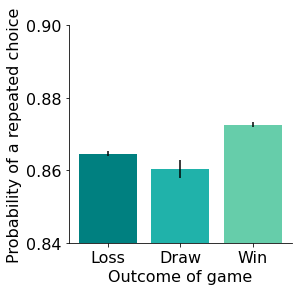

In [75]:
# Plot the win-stay, lose-shift probabilities for the SD
fig, ax = plt.subplots(figsize=(4,4))
colors = ['teal', 'lightseagreen', 'mediumaquamarine']

x = [1,2,3]
ax.bar(x,[m for m,s in means], color=[c for c in colors])
ax.errorbar(x,y=[m for m,s in means],yerr=[s for m,s in means],linestyle='None',color='black')
ax.set_xticks(x)
ax.set_xticklabels(['Loss','Draw','Win'])
ax.set_yticks([0.84, 0.86, 0.88, 0.9])
ax.set_ylim([0.84,0.9])
ax.set_ylabel('Probability of a repeated choice')
ax.set_xlabel('Outcome of game')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('RL_repeat.png', format='png', dpi=1000,bbox_inches = 'tight')

In [76]:
# Test for significance
loss = [code[icurr]==code[iprev] for icurr,iprev in enumerate(df_binary['last_game_as_white']) 
                           if iprev>=0 and result[iprev]==0]
win = [code[icurr]==code[iprev] for icurr,iprev in enumerate(df_binary['last_game_as_white']) 
                           if iprev>=0 and result[iprev]==1]

print(st.ttest_ind(loss, win))

Ttest_indResult(statistic=-8.638003876516105, pvalue=5.735850268186712e-18)


In [77]:
# Repeat for the opponent's move
result = df_binary['result'].values
code = df_binary['thirdcode'].values

means = [get_mean_and_sem([code[icurr]==code[iprev] for icurr,iprev in enumerate(df_binary['last_game_as_black']) 
                           if iprev>=0 and result[iprev]==res]) for res in [1,0.5,0]]

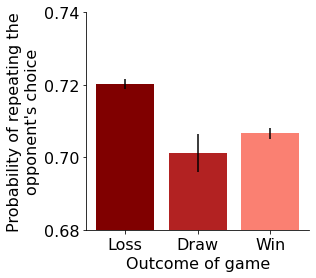

In [78]:
# Plot the win-stay, lose-shift probabilities for the SD
fig, ax = plt.subplots(figsize=(4,4))
colors = ['maroon', 'firebrick', 'salmon']

x = [1,2,3]
ax.bar(x,[m for m,s in means], color=[c for c in colors])
ax.errorbar(x,y=[m for m,s in means],yerr=[s for m,s in means],linestyle='None',color='black')
ax.set_xticks(x)
ax.set_xticklabels(['Loss','Draw','Win'])
ax.set_yticks([0.68, 0.7, 0.72, 0.74])
ax.set_ylim([0.68,0.74])
ax.set_ylabel('Probability of repeating the\nopponent\'s choice')
ax.set_xlabel('Outcome of game')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('opp_RL_repeat.png', format='png', dpi=1000,bbox_inches = 'tight')

In [79]:
# Test for significance
loss = [code[icurr]==code[iprev] for icurr,iprev in enumerate(df_binary['last_game_as_black']) 
                           if iprev>=0 and result[iprev]==1]
win = [code[icurr]==code[iprev] for icurr,iprev in enumerate(df_binary['last_game_as_black']) 
                           if iprev>=0 and result[iprev]==0]

print(st.ttest_ind(loss, win))

Ttest_indResult(statistic=6.633556802846028, pvalue=3.285549970041971e-11)


In [80]:
# Repeat for copy effect
result = df_binary['result'].values
code = df_binary['thirdcode'].values

means = [get_mean_and_sem([code[icurr]=='O' for icurr,iprev in enumerate(df_binary['last_game_as_black']) 
                           if iprev>=0 and code[iprev]==opp_code]) for opp_code in ['C','O']]

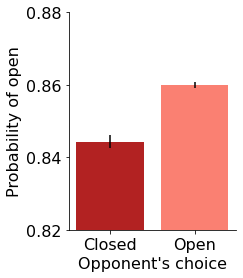

In [81]:
# Plot
fig, ax = plt.subplots(figsize=(3,4))
colors = ['firebrick', 'salmon']

x = [1,2]
ax.bar(x,[m for m,s in means], color=[c for c in colors])
ax.errorbar(x,y=[m for m,s in means],yerr=[s for m,s in means],linestyle='None',color='black')
ax.set_xticks(x)
ax.set_xticklabels(['Closed','Open'])
ax.set_yticks([0.82, 0.84, 0.86, 0.88])
ax.set_ylim([0.82,0.88])
ax.set_ylabel('Probability of open')
ax.set_xlabel('Opponent\'s choice')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('opp_copy.png', format='png', dpi=1000,bbox_inches = 'tight')

In [82]:
# Test for significance
accept = [code[icurr]=='O' for icurr,iprev in enumerate(df_binary['last_game_as_black']) 
                           if iprev>=0 and code[iprev]=='C']
decline = [code[icurr]=='O' for icurr,iprev in enumerate(df_binary['last_game_as_black']) 
                           if iprev>=0 and code[iprev]=='O']

print(st.ttest_ind(accept, decline))

Ttest_indResult(statistic=-8.078815048303486, pvalue=6.575845745860087e-16)


In [83]:
# Compute the index of the nth SD game back as white
nback = last_game_as_white
for n in range(1,31):
    df_binary['white_game_' + str(n) + '_back'] = nback
    nback = [last_game_as_white[i] if i>=0 else -1 for i in nback]

In [84]:
df_binary

,black,white,start_time,thirdmove,rt,result,blackelo,whiteelo,num_black_games,num_white_games,...,white_game_21_back,white_game_22_back,white_game_23_back,white_game_24_back,white_game_25_back,white_game_26_back,white_game_27_back,white_game_28_back,white_game_29_back,white_game_30_back
0,Kami_of_Honmaru,wonderingblunder,1.601525e+09,b1c3,4.0,1.0,1194,1121,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,jy3,Scratchman,1.601525e+09,g1f3,1.0,0.0,1073,1194,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,dermaxe,Pandi9595,1.601525e+09,b1c3,2.0,1.0,1036,1134,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,duliomarcio,Raptorax,1.601525e+09,g1f3,-1.0,0.0,1145,1158,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,cris15chess2020,AdrianHR2020,1.601525e+09,g1f3,1.0,1.0,1078,1168,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714213,Dancheco,jamin34,1.617249e+09,g1f3,4.0,1.0,893,910,7,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
714214,Animal-pant,TarumarRiayet,1.617250e+09,g1f3,3.0,1.0,921,966,97,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
714215,DawsonRicardo,aruniyer88,1.617250e+09,g1f3,2.0,1.0,1024,1005,12,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
714216,Arteaga1811,Kh0nsu,1.617250e+09,g1f3,5.0,1.0,916,851,1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [85]:
# Compute the win-stay, lose-shift mean and sem for the SD 2 games back
rl_probs = np.zeros((4,4))
rl_count = np.zeros((4,4))
rl_vals = [[] for x in range(16)]

result = df_binary['result'].values
code = df_binary['thirdcode'].values

# Loop through the dataframe
for ind in df_binary.index:
    
    # Grab the previous 2 indices, results, and codes as black
    res = df_binary['result'][ind]
    iprev1 = df_binary['white_game_1_back'][ind]
    iprev2 = df_binary['white_game_2_back'][ind]
    res1 = result[iprev1]
    res2 = result[iprev2]
    code1 = code[iprev1]
    code2 = code[iprev2]
    
    # If there is a 2 game history
    if iprev1 >= 0 and iprev2 >= 0:
        
        # Check if there was a repetition
        if code[ind] == code1:
            repeat = 1
        else:
            repeat = 0
        
        # Assign it to the correct part of the array
        if code2 == 'C' and res2 == 0 and code1 == 'C' and res1 == 0:
            rl_vals[0].append(repeat)
        elif code2 == 'C' and res2 == 0 and code1 == 'C' and res1 == 1:
            rl_vals[1].append(repeat)
        elif code2 == 'C' and res2 == 0 and code1 == 'O' and res1 == 0:
            rl_vals[2].append(repeat)
        elif code2 == 'C' and res2 == 0 and code1 == 'O' and res1 == 1:
            rl_vals[3].append(repeat)
            
        elif code2 == 'C' and res2 == 1 and code1 == 'C' and res1 == 0:
            rl_vals[4].append(repeat)
        elif code2 == 'C' and res2 == 1 and code1 == 'C' and res1 == 1:
            rl_vals[5].append(repeat)
        elif code2 == 'C' and res2 == 1 and code1 == 'O' and res1 == 0:
            rl_vals[6].append(repeat)
        elif code2 == 'C' and res2 == 1 and code1 == 'O' and res1 == 1:
            rl_vals[7].append(repeat)
            
        elif code2 == 'O' and res2 == 0 and code1 == 'C' and res1 == 0:
            rl_vals[8].append(repeat)
        elif code2 == 'O' and res2 == 0 and code1 == 'C' and res1 == 1:
            rl_vals[9].append(repeat)
        elif code2 == 'O' and res2 == 0 and code1 == 'O' and res1 == 0:
            rl_vals[10].append(repeat)
        elif code2 == 'O' and res2 == 0 and code1 == 'O' and res1 == 1:
            rl_vals[11].append(repeat)
            
        elif code2 == 'O' and res2 == 1 and code1 == 'C' and res1 == 0:
            rl_vals[12].append(repeat)
        elif code2 == 'O' and res2 == 1 and code1 == 'C' and res1 == 1:
            rl_vals[13].append(repeat)
        elif code2 == 'O' and res2 == 1 and code1 == 'O' and res1 == 0:
            rl_vals[14].append(repeat)
        elif code2 == 'O' and res2 == 1 and code1 == 'O' and res1 == 1:
            rl_vals[15].append(repeat)


In [86]:
# Compute all combinations of the probabilities
means = []
sems = []

for i in range(16):
    means.append(np.mean(rl_vals[i]))
    sems.append(stats.sem(rl_vals[i]))
    
means

[0.7830012453300125,
 0.7832995793737342,
 0.6969872537659328,
 0.6998163582426896,
 0.7797101449275362,
 0.7945299405759562,
 0.6812397065428957,
 0.6930149784962183,
 0.4017467248908297,
 0.4169512573734865,
 0.947820631018234,
 0.9500978473581213,
 0.39964504678928686,
 0.4184185754628177,
 0.9486688129183913,
 0.9519032127846508]

In [87]:
# Generate a colormap
data = [i for i in range(18)]
denominator = max(data) - min(data)
scaled_data = [(datum-min(data))/denominator for datum in data]
colors = []
cmap = plt.cm.get_cmap('Greens_r')
for decimal in scaled_data:
    colors.append(cmap(decimal))

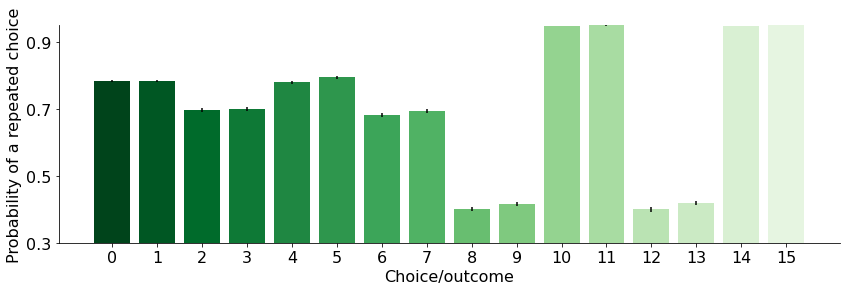

In [88]:
# Plot
fig, ax = plt.subplots(figsize=(14,4))
ax.bar(np.arange(16), means, color=colors)
ax.errorbar(np.arange(16), means,yerr=sems,linestyle='None',color='black')
ax.set_xticks(np.arange(16))
ax.set_ylim([0.3,.95])
ax.set_yticks([0.3,.5,.7,.9,])
ax.set_ylabel('Probability of a repeated choice')
ax.set_xlabel('Choice/outcome')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('RL_tree.png', format='png', dpi=1000,bbox_inches = 'tight')

In [90]:
# Test for significance (stay vs. shift with same outcomes and initial choice)
print(st.ttest_ind(rl_vals[0], rl_vals[2]))
print(st.ttest_ind(rl_vals[1], rl_vals[3]))
print(st.ttest_ind(rl_vals[4], rl_vals[6]))
print(st.ttest_ind(rl_vals[5], rl_vals[7]))
print(st.ttest_ind(rl_vals[8], rl_vals[10]))
print(st.ttest_ind(rl_vals[9], rl_vals[11]))
print(st.ttest_ind(rl_vals[12], rl_vals[14]))
print(st.ttest_ind(rl_vals[13], rl_vals[15]))

Ttest_indResult(statistic=13.42451729807577, pvalue=6.566449661803522e-41)
Ttest_indResult(statistic=13.143197774132906, pvalue=2.713779718875296e-39)
Ttest_indResult(statistic=15.063496362264962, pvalue=5.461389493437758e-51)
Ttest_indResult(statistic=15.966801976421873, pvalue=4.928693077304144e-57)
Ttest_indResult(statistic=-166.23447064729032, pvalue=0.0)
Ttest_indResult(statistic=-165.2449420174551, pvalue=0.0)
Ttest_indResult(statistic=-166.12541829973938, pvalue=0.0)
Ttest_indResult(statistic=-168.09644001334686, pvalue=0.0)


In [89]:
# Test for significance (loss vs. win on last game)
print(st.ttest_ind(rl_vals[0], rl_vals[1]))
print(st.ttest_ind(rl_vals[2], rl_vals[3]))
print(st.ttest_ind(rl_vals[4], rl_vals[5]))
print(st.ttest_ind(rl_vals[6], rl_vals[7]))
print(st.ttest_ind(rl_vals[8], rl_vals[9]))
print(st.ttest_ind(rl_vals[10], rl_vals[11]))
print(st.ttest_ind(rl_vals[12], rl_vals[13]))
print(st.ttest_ind(rl_vals[14], rl_vals[15]))

Ttest_indResult(statistic=-0.058009912766020126, pvalue=0.9537411838594794)
Ttest_indResult(statistic=-0.364415090912037, pvalue=0.7155535794153479)
Ttest_indResult(statistic=-2.9133177525817153, pvalue=0.003579162664393954)
Ttest_indResult(statistic=-1.4711450025745039, pvalue=0.1412753536811751)
Ttest_indResult(statistic=-1.7529274249403288, pvalue=0.07963830628409989)
Ttest_indResult(statistic=-2.0553661192369064, pvalue=0.03984529726631592)
Ttest_indResult(statistic=-2.1406126167583106, pvalue=0.032324472894992504)
Ttest_indResult(statistic=-2.999092774643159, pvalue=0.0027082582633292072)


In [91]:
# Create an array with the outcomes of the previous games
X = np.array([[0.5 if iprev==-1 else 
               (df_binary['result'][iprev] if df_binary['thirdcode'][iprev]=='O' else 1-df_binary['result'][iprev]) 
               for iprev in df_binary['white_game_' + str(n) + '_back']] for n in range(1,31)])

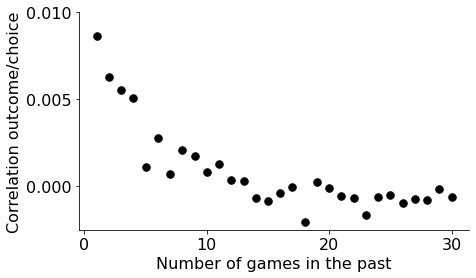

In [92]:
# Plot the correlation between outcome of previous games and choice in current game
fig, ax = plt.subplots(figsize=(7,4))

ax.plot(range(1,31),[np.corrcoef(X[n,:],df_binary['thirdcode']=='O')[0,1] for n in range(30)],'.',markersize=15, color='black')
ax.set_xlabel('Number of games in the past')
ax.set_ylabel('Correlation outcome/choice')
ax.set_yticks(np.arange(0,.0125,.005))
ax.set_xticks([0,10,20,30])
ax.set_ylim([-.0025,0.01])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('RL_corr.png', format='png', dpi=1000,bbox_inches = 'tight')

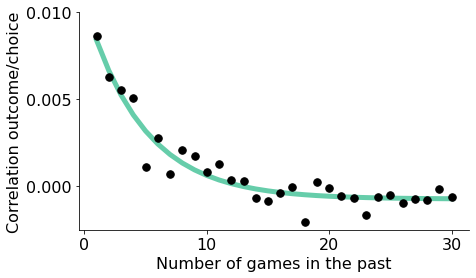

In [93]:
# Same plot with an exponential fit
popt, pcov = curve_fit(exp_func, range(1,31), [np.corrcoef(X[n,:],df_binary['thirdcode']=='O')[0,1] for n in range(30)])

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(range(1,31), exp_func(range(1,31), *popt), lw=5, color='mediumaquamarine')
ax.plot(range(1,31),[np.corrcoef(X[n,:],df_binary['thirdcode']=='O')[0,1] for n in range(30)],'.',markersize=15, color='black')
ax.set_xlabel('Number of games in the past')
ax.set_ylabel('Correlation outcome/choice')
ax.set_yticks(np.arange(0,.0125,.005))
ax.set_xticks([0,10,20,30])
ax.set_ylim([-.0025,0.01])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('RL_corr.png', format='png', dpi=1000,bbox_inches = 'tight')

In [94]:
# Compute the mean and sem binned for response time vs. probability of open
all_rt = df_binary.loc[df_binary['rt'] >= 0]['rt'].values
all_codes = df_binary.loc[df_binary['rt'] >= 0]['thirdcode'].values
all_codes_binary = np.where(all_codes == 'O', 1, 0)

bin_means, bin_edges, binnumber = binned_statistic(all_rt, all_codes_binary, statistic='mean', bins=10, range=(0, 10))
bin_sem, bin_edges_sem, binnumber_sem = binned_statistic(all_rt, all_codes_binary, statistic=stats.sem, bins=10, range=(0, 10))

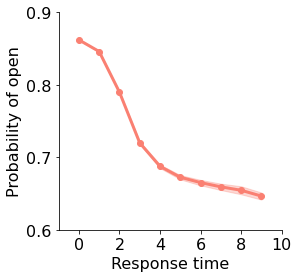

In [95]:
# Plot
fig, ax = plt.subplots(figsize=(4,4))

ax.errorbar(bin_edges[:-1], bin_means, marker='o', color='salmon', lw=3)
ax.fill_between(bin_edges[:-1], bin_means-bin_sem, bin_means+bin_sem, color='salmon', alpha=0.3)
ax.set_ylabel('Probability of open')
ax.set_xlabel('Response time')
ax.set_xlim(-1, 10)
ax.set_ylim(0.6,0.9)
ax.set_xticks([0, 2, 4, 6, 8, 10])
ax.set_yticks([0.6, 0.7, 0.8, 0.9])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('rt_open.png', format='png', dpi=1000,bbox_inches = 'tight')

In [96]:
# Compute the mean and sem binned for elo rating vs. probability of open
all_elo = df_binary.loc[df_binary['whiteelo'] >= 0]['whiteelo'].values
all_codes = df_binary.loc[df_binary['whiteelo'] >= 0]['thirdcode'].values
all_codes_binary = np.where(all_codes == 'O', 1, 0)

bin_means, bin_edges, binnumber = binned_statistic(all_elo, all_codes_binary, statistic='mean', bins=10, range=(800, 1200))
bin_sem, bin_edges_sem, binnumber_sem = binned_statistic(all_elo, all_codes_binary, statistic=stats.sem, bins=10, range=(800, 1200))

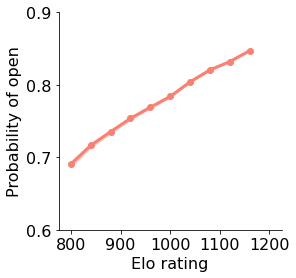

In [97]:
# Plot
fig, ax = plt.subplots(figsize=(4,4))

ax.errorbar(bin_edges[:-1], bin_means, marker='o', color='salmon', lw=3)
ax.fill_between(bin_edges[:-1], bin_means-bin_sem, bin_means+bin_sem, color='salmon', alpha=0.3)
ax.set_ylabel('Probability of open')
ax.set_xlabel('Elo rating')
ax.set_xlim(775, 1225)
ax.set_ylim(0.6,0.9)
ax.set_xticks([800, 900, 1000, 1100, 1200])
ax.set_yticks([0.6, 0.7, 0.8, 0.9])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('elo_open.png', format='png', dpi=1000,bbox_inches = 'tight')

In [98]:
# Compute the correlation between player and opponent elo
print(df_binary['blackelo'].corr(df_binary['whiteelo']))

0.7996957358110398


Text(0, 0.5, 'Number of games')

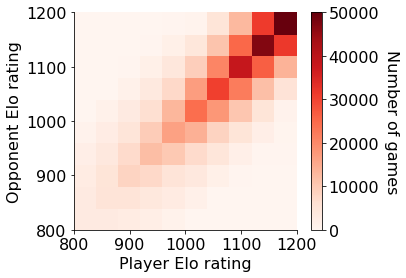

In [99]:
player_elo = df_binary['blackelo'].values
opp_elo = df_binary['whiteelo'].values

# Plot
fig, ax = plt.subplots(figsize=(5,4))

counts, xedges, yedges, im = ax.hist2d(player_elo, opp_elo, cmap=plt.cm.Reds, vmin=0, vmax=50000)
ax.set_ylabel('Opponent Elo rating')
ax.set_xlabel('Player Elo rating')
ax.set_xticks([800, 900, 1000, 1100, 1200])
ax.set_yticks([800, 900, 1000, 1100, 1200])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Number of games', rotation=-90, labelpad=20)

# plt.savefig('elo_corr.png', format='png', dpi=1000,bbox_inches = 'tight')

In [100]:
# Loop through the dataframe and compute time gap from last game as black/white
gap_black = []
gap_white = []

for ind in df_binary.index:
    
    # Grab the previous indices
    iprev_black = df_binary['last_game_as_black'][ind]
    iprev_white = df_binary['last_game_as_white'][ind]
    
    # Compute the time difference in seconds
    if iprev_black >= 0:
        curr_time = df_binary['start_time'][ind]
        prev_time = df_binary['start_time'][iprev_black]
        gap_black.append(curr_time-prev_time)
        
    else:
        gap_black.append(-1)
        
    if iprev_white >= 0:
        curr_time = df_binary['start_time'][ind]
        prev_time = df_binary['start_time'][iprev_white]
        gap_white.append(curr_time-prev_time)
        
    else:
        gap_white.append(-1)

In [101]:
# Add the time gap to the dataframe
df_binary['gap_black'] = gap_black
df_binary['gap_white'] = gap_white

In [102]:
df_binary

,black,white,start_time,thirdmove,rt,result,blackelo,whiteelo,num_black_games,num_white_games,...,white_game_23_back,white_game_24_back,white_game_25_back,white_game_26_back,white_game_27_back,white_game_28_back,white_game_29_back,white_game_30_back,gap_black,gap_white
0,Kami_of_Honmaru,wonderingblunder,1.601525e+09,b1c3,4.0,1.0,1194,1121,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1.0,-1.0
1,jy3,Scratchman,1.601525e+09,g1f3,1.0,0.0,1073,1194,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1.0,-1.0
2,dermaxe,Pandi9595,1.601525e+09,b1c3,2.0,1.0,1036,1134,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1.0,-1.0
3,duliomarcio,Raptorax,1.601525e+09,g1f3,-1.0,0.0,1145,1158,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1.0,-1.0
4,cris15chess2020,AdrianHR2020,1.601525e+09,g1f3,1.0,1.0,1078,1168,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714213,Dancheco,jamin34,1.617249e+09,g1f3,4.0,1.0,893,910,7,0,...,-1,-1,-1,-1,-1,-1,-1,-1,2570702.0,382.0
714214,Animal-pant,TarumarRiayet,1.617250e+09,g1f3,3.0,1.0,921,966,97,0,...,-1,-1,-1,-1,-1,-1,-1,-1,15887.0,16509.0
714215,DawsonRicardo,aruniyer88,1.617250e+09,g1f3,2.0,1.0,1024,1005,12,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1.0,376831.0
714216,Arteaga1811,Kh0nsu,1.617250e+09,g1f3,5.0,1.0,916,851,1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1.0,232480.0


In [103]:
# Compute the gap irrespective of color
time = []
time_codes = []

for ind in df_binary.index:
    
    gap_black = df_binary['gap_black'][ind]
    gap_white = df_binary['gap_white'][ind]
    min_time = min(gap_black, gap_white)
    max_time = max(gap_black, gap_white)
    
    if min_time >= 0:
        time.append(min_time)
        time_codes.append(df_binary['thirdcode'][ind])
    elif max_time >= 0:
        time.append(max_time)
        time_codes.append(df_binary['thirdcode'][ind])        

In [104]:
# Compute the mean and sem binned for gap vs. probability of decline
time_codes_binary = np.where(np.asarray(time_codes) == 'O', 1, 0)

bin_means, bin_edges, binnumber = binned_statistic(np.asarray(time)/(60*60*24), time_codes_binary, statistic='mean', bins=10, range=(0, 20))
bin_sem, bin_edges_sem, binnumber_sem = binned_statistic(np.asarray(time)/(60*60*24), time_codes_binary, statistic=stats.sem, bins=10, range=(0, 20))

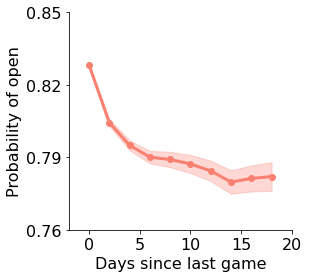

In [105]:
fig, ax = plt.subplots(figsize=(4,4))
ax.errorbar(bin_edges[:-1], bin_means, marker='o', color='salmon', lw=3)
ax.fill_between(bin_edges[:-1], bin_means-bin_sem, bin_means+bin_sem, color='salmon', alpha=0.3)
ax.set_ylabel('Probability of open')
ax.set_xlabel('Days since last game')
ax.set_xlim(-2, 20)
ax.set_ylim(0.76,0.85)
ax.set_xticks([0, 5, 10, 15, 20])
ax.set_yticks([0.76, 0.79, 0.82, 0.85])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('time_open.png', format='png', dpi=1000,bbox_inches = 'tight')

## King's Knight

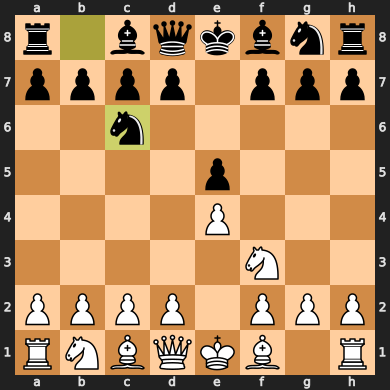

In [9]:
# Visualize the King's Knight
board = chess.Board()
board.push_san('e4')
board.push_san('e5')
board.push_san('Nf3')
board.push_san('Nc6')
board

In [9]:
# Save out the board image
boardsvg = chess.svg.board(board)
outputfile = open('kings_knight.svg', "w")
outputfile.write(boardsvg)
outputfile.close()

In [107]:
# Load the csv data of KK games (October 2020 - March 2021)
direc = '../../Data/kings_knight/'

df = pd.concat([pd.read_csv(direc + 'df_{:d}_{:02d}.csv'.format(2020 + j//12,j%12+1),
                            usecols=['white','black','start_time','fifthmove','rt','result', 'blackelo', 'whiteelo',
                                     'num_black_games','num_white_games'])
                for j in range(9,15)],ignore_index=True)

In [108]:
# Load the pkl data of unique players (March 2020 - September 2020)
players = []
for i in range(3,9):
    with open(direc + 'KK_players_2020_{:02d}.pkl'.format(i),'rb') as f:
        players = pickle.load(f)
s = set(np.array(players).flatten())

# Filter out players who have played the SD in this period
df = df[df['white'].apply(lambda p: not p in s)].reset_index(drop=True)

In [109]:
# Add italian, ruy lopez, or other to df
df['fifthcode'] = df['fifthmove'].map({'f1c4' : 'I', 'f1b5' : 'R'}).fillna('O')

# Add move index to df
unique_fifthmoves,_ = get_ordered_unique_values(df['fifthmove'].astype(str))
move_to_index = {m:i for i,m in enumerate(unique_fifthmoves)}
df['fifthindex'] = np.array([move_to_index[m] for m in df['fifthmove'].astype(str)])

In [110]:
move_to_index

{'f1c4': 0,
 'b1c3': 1,
 'f1b5': 2,
 'd2d4': 3,
 'c2c3': 4,
 'd2d3': 5,
 'g2g3': 6,
 'b2b3': 7,
 'c2c4': 8,
 'f1e2': 9,
 'f1d3': 10,
 'a2a3': 11,
 'f3e5': 12,
 'f3g5': 13,
 'h2h3': 14,
 'd1e2': 15,
 'h2h4': 16,
 'nan': 17,
 'g2g4': 18,
 'b2b4': 19,
 'a2a4': 20,
 'b1a3': 21,
 'f3g1': 22,
 'f3h4': 23,
 'f3d4': 24,
 'e1e2': 25,
 'f1a6': 26,
 'h1g1': 27}

In [111]:
# View the remaining data
df

,black,white,start_time,fifthmove,rt,result,blackelo,whiteelo,num_black_games,num_white_games,fifthcode,fifthindex
0,RIFQIPEBRIAN123,Daniel_Kundera,1.601536e+09,f1c4,2.0,0.0,1066,1078,0,0,I,0
1,Vikingo2001,oldmangrayshirt,1.601536e+09,f1c4,3.0,1.0,1056,1037,0,0,I,0
2,Admin_Noob,apriori96,1.601536e+09,b1c3,1.0,1.0,1089,1114,0,0,O,1
3,DobbsNZ,gantulg,1.601536e+09,f1b5,1.0,1.0,1121,1178,0,0,R,2
4,juanibm,KryptideBTW,1.601536e+09,d2d4,1.0,1.0,1151,1118,0,0,O,3
...,...,...,...,...,...,...,...,...,...,...,...,...
2213603,Senku_virtuose,Me4kata,1.617260e+09,f1c4,1.0,1.0,975,896,1,1,I,0
2213604,M2nero,deviengeorge,1.617260e+09,f1b5,1.0,0.0,1045,1015,8,1,R,2
2213605,TheGeneralZod,xuny,1.617260e+09,b1c3,6.0,1.0,972,1008,9,0,O,1
2213606,waggledook,PLVST_Music,1.617260e+09,c2c3,0.0,1.0,1048,932,20,0,O,4


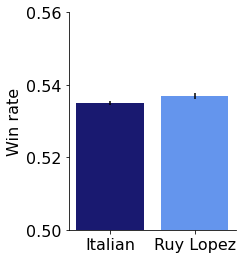

In [112]:
# Plot the overall win rate for italian/ruy lopez KK
fig, ax = plt.subplots(figsize=(3,4))

df_by_code = df[df['fifthcode'].isin(['I','R'])].groupby('fifthcode')['result'].agg(['mean','sem']).reset_index()
ax.bar(range(len(df_by_code)),df_by_code['mean'], color=['midnightblue', 'cornflowerblue'])
ax.errorbar(x=range(len(df_by_code)),y=df_by_code['mean'],yerr=df_by_code['sem'],linestyle='None',color='black')
ax.set_xticks(range(len(df_by_code)))
ax.set_xticklabels(['Italian', 'Ruy Lopez'])
ax.set_yticks([0.5, 0.52, .54, .56])
ax.set_ylim([0.5,0.56])
ax.set_ylabel('Win rate')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('winrate.png', format='png', dpi=1000,bbox_inches = 'tight')

In [113]:
# Test for significance
italian = [df['result'][icurr] for icurr in range(len(df)) if df['fifthcode'][icurr]=='I']
ruy = [df['result'][icurr] for icurr in range(len(df)) if df['fifthcode'][icurr]=='R']
italian = np.asarray(italian)
ruy = np.asarray(ruy)
italian = italian[~np.isnan(italian)]
ruy = ruy[~np.isnan(ruy)]

print(st.ttest_ind(italian, ruy))

Ttest_indResult(statistic=-1.920080445879767, pvalue=0.05484797058878956)


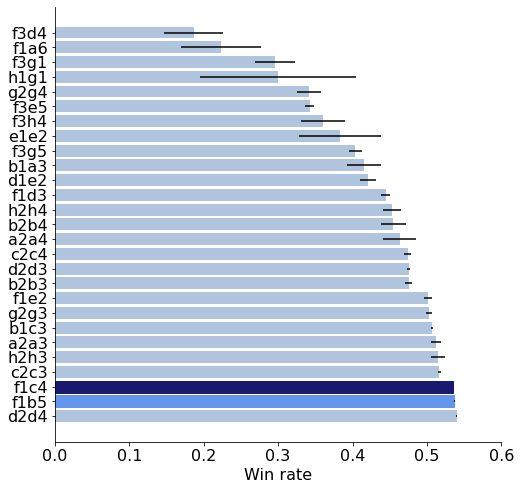

In [114]:
# Plot the win rate for different responses to the KK
fig, ax = plt.subplots(figsize=(8,8))

df_by_move = df.groupby('fifthmove')['result'].agg(['mean','sem']).sort_values('mean').reset_index()
barlist = ax.barh(range(len(df_by_move)),df_by_move['mean'], color='lightsteelblue')
ax.errorbar(y=range(len(df_by_move)),x=df_by_move['mean'],xerr=df_by_move['sem'],linestyle='None',color='black')
ax.set_yticks(range(len(df_by_move)))
ax.set_yticklabels(labels=df_by_move['fifthmove'])
ax.set_xlabel('Win rate')
ax.set_xlim(0,.56)
ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5,0.6])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

barlist[24].set_color('midnightblue')
barlist[25].set_color('cornflowerblue')
plt.gca().invert_yaxis()

# plt.savefig('responses_winrate.png', format='png', dpi=1000,bbox_inches = 'tight')

In [115]:
# Create a binary dataframe of just italian/ruy lopez
df_binary = df[(df['fifthcode'].isin(['I','R'])) & (~df['result'].isna())].reset_index(drop=True)
names,ind = np.unique(df_binary['white'],return_inverse=True)
name_to_ind = dict(zip(names,ind))

df_binary

,black,white,start_time,fifthmove,rt,result,blackelo,whiteelo,num_black_games,num_white_games,fifthcode,fifthindex
0,RIFQIPEBRIAN123,Daniel_Kundera,1.601536e+09,f1c4,2.0,0.0,1066,1078,0,0,I,0
1,Vikingo2001,oldmangrayshirt,1.601536e+09,f1c4,3.0,1.0,1056,1037,0,0,I,0
2,DobbsNZ,gantulg,1.601536e+09,f1b5,1.0,1.0,1121,1178,0,0,R,2
3,f1gn2r,AhmedEinstein,1.601536e+09,f1c4,-1.0,0.0,1119,1175,0,0,I,0
4,KnowUrSelf,RSTD2006,1.601536e+09,f1c4,4.0,1.0,964,974,0,0,I,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1225905,saani3620,DrewReallyDo,1.617260e+09,f1c4,1.0,1.0,1140,1151,5,14,I,0
1225906,Panfi,rsastre,1.617260e+09,f1b5,-1.0,0.0,1040,1105,17,12,R,2
1225907,Senku_virtuose,Me4kata,1.617260e+09,f1c4,1.0,1.0,975,896,1,1,I,0
1225908,M2nero,deviengeorge,1.617260e+09,f1b5,1.0,0.0,1045,1015,8,1,R,2


In [116]:
# Compute the number of unique players that played the opening
len(np.unique(df_binary['white']))

167331

In [117]:
# Compute the percentage of moves that reduction contains
len(df_binary)/len(df)

0.5538062746430262

In [118]:
# Compute the index of the last game as black/white for each KK game
last_game_as_white = [None]*len(df_binary)
last_game_as_black = [None]*len(df_binary)

d_black = defaultdict(lambda: -1)
d_white = defaultdict(lambda: -1)

for i,row in df_binary.iterrows():
    
    last_game_as_white[i] = d_white[row['white']]
    last_game_as_black[i] = d_black[row['white']]
    d_white[row['white']] = i
    d_black[row['black']] = i
    
    if i%100000==0:
        print(i)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000


In [119]:
# Add these to the dataframe
df_binary['last_game_as_white'] = last_game_as_white
df_binary['last_game_as_black'] = last_game_as_black

df_binary

,black,white,start_time,fifthmove,rt,result,blackelo,whiteelo,num_black_games,num_white_games,fifthcode,fifthindex,last_game_as_white,last_game_as_black
0,RIFQIPEBRIAN123,Daniel_Kundera,1.601536e+09,f1c4,2.0,0.0,1066,1078,0,0,I,0,-1,-1
1,Vikingo2001,oldmangrayshirt,1.601536e+09,f1c4,3.0,1.0,1056,1037,0,0,I,0,-1,-1
2,DobbsNZ,gantulg,1.601536e+09,f1b5,1.0,1.0,1121,1178,0,0,R,2,-1,-1
3,f1gn2r,AhmedEinstein,1.601536e+09,f1c4,-1.0,0.0,1119,1175,0,0,I,0,-1,-1
4,KnowUrSelf,RSTD2006,1.601536e+09,f1c4,4.0,1.0,964,974,0,0,I,0,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225905,saani3620,DrewReallyDo,1.617260e+09,f1c4,1.0,1.0,1140,1151,5,14,I,0,1225340,1185551
1225906,Panfi,rsastre,1.617260e+09,f1b5,-1.0,0.0,1040,1105,17,12,R,2,1225187,-1
1225907,Senku_virtuose,Me4kata,1.617260e+09,f1c4,1.0,1.0,975,896,1,1,I,0,1225807,1225571
1225908,M2nero,deviengeorge,1.617260e+09,f1b5,1.0,0.0,1045,1015,8,1,R,2,-1,-1


In [120]:
# Compute the win-stay, lose-shift mean and sem for the KK
result = df_binary['result'].values
code = df_binary['fifthcode'].values

means = [get_mean_and_sem([code[icurr]==code[iprev] for icurr,iprev in enumerate(df_binary['last_game_as_white']) 
                           if iprev>=0 and result[iprev]==res]) for res in [0,0.5,1]]

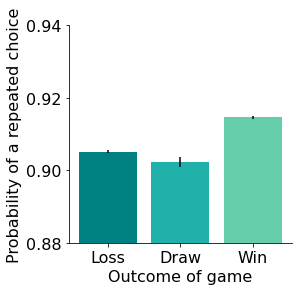

In [121]:
# Plot the win-stay, lose-shift probabilities for the KK
fig, ax = plt.subplots(figsize=(4,4))
colors = ['teal', 'lightseagreen', 'mediumaquamarine']

x = [1,2,3]
ax.bar(x,[m for m,s in means], color=[c for c in colors])
ax.errorbar(x,y=[m for m,s in means],yerr=[s for m,s in means],linestyle='None',color='black')
ax.set_xticks(x)
ax.set_xticklabels(['Loss','Draw','Win'])
ax.set_yticks([0.88, 0.9, .92, .94])
ax.set_ylim([0.88,0.94])
ax.set_ylabel('Probability of a repeated choice')
ax.set_xlabel('Outcome of game')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('RL_repeat.png', format='png', dpi=1000,bbox_inches = 'tight')

In [122]:
# Test for significance
loss = [code[icurr]==code[iprev] for icurr,iprev in enumerate(df_binary['last_game_as_white']) 
                           if iprev>=0 and result[iprev]==0]
win = [code[icurr]==code[iprev] for icurr,iprev in enumerate(df_binary['last_game_as_white']) 
                           if iprev>=0 and result[iprev]==1]

print(st.ttest_ind(loss, win))

Ttest_indResult(statistic=-16.775594657273796, pvalue=3.7543019432061004e-63)


In [123]:
# Repeat for the opponent's move
result = df_binary['result'].values
code = df_binary['fifthcode'].values

means = [get_mean_and_sem([code[icurr]==code[iprev] for icurr,iprev in enumerate(df_binary['last_game_as_black']) 
                           if iprev>=0 and result[iprev]==res]) for res in [1,0.5,0]]

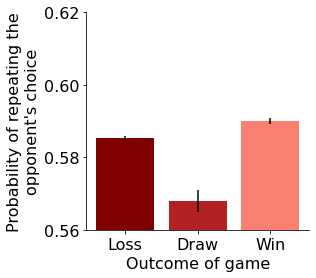

In [124]:
# Plot the win-stay, lose-shift probabilities for the KK
fig, ax = plt.subplots(figsize=(4,4))
colors = ['maroon', 'firebrick', 'salmon']

x = [1,2,3]
ax.bar(x,[m for m,s in means], color=[c for c in colors])
ax.errorbar(x,y=[m for m,s in means],yerr=[s for m,s in means],linestyle='None',color='black')
ax.set_xticks(x)
ax.set_xticklabels(['Loss','Draw','Win'])
ax.set_yticks([0.56, 0.58, 0.6, 0.62])
ax.set_ylim([0.56,0.62])
ax.set_ylabel('Probability of repeating the\nopponent\'s choice')
ax.set_xlabel('Outcome of game')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('opp_RL_repeat.png', format='png', dpi=1000,bbox_inches = 'tight')

In [125]:
# Test for significance
loss = [code[icurr]==code[iprev] for icurr,iprev in enumerate(df_binary['last_game_as_black']) 
                           if iprev>=0 and result[iprev]==1]
win = [code[icurr]==code[iprev] for icurr,iprev in enumerate(df_binary['last_game_as_black']) 
                           if iprev>=0 and result[iprev]==0]

print(st.ttest_ind(loss, win))

Ttest_indResult(statistic=-4.249350393181809, pvalue=2.1441732045941376e-05)


In [126]:
# Repeat for copy effect
result = df_binary['result'].values
code = df_binary['fifthcode'].values

means = [get_mean_and_sem([code[icurr]=='R' for icurr,iprev in enumerate(df_binary['last_game_as_black']) 
                           if iprev>=0 and code[iprev]==opp_code]) for opp_code in ['I','R']]

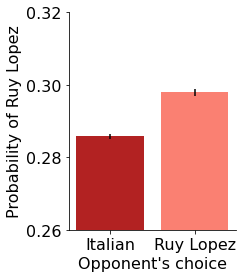

In [127]:
# Plot
fig, ax = plt.subplots(figsize=(3,4))
colors = ['firebrick', 'salmon']

x = [1,2]
ax.bar(x,[m for m,s in means], color=[c for c in colors])
ax.errorbar(x,y=[m for m,s in means],yerr=[s for m,s in means],linestyle='None',color='black')
ax.set_xticks(x)
ax.set_xticklabels(['Italian','Ruy Lopez'])
ax.set_yticks([0.26, 0.28, 0.3, 0.32])
ax.set_ylim([0.26,0.32])
ax.set_ylabel('Probability of Ruy Lopez')
ax.set_xlabel('Opponent\'s choice')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('opp_copy.png', format='png', dpi=1000,bbox_inches = 'tight')

In [128]:
# Test for significance
accept = [code[icurr]=='R' for icurr,iprev in enumerate(df_binary['last_game_as_black']) 
                           if iprev>=0 and code[iprev]=='I']
decline = [code[icurr]=='R' for icurr,iprev in enumerate(df_binary['last_game_as_black']) 
                           if iprev>=0 and code[iprev]=='R']

print(st.ttest_ind(accept, decline))

Ttest_indResult(statistic=-10.841662162969092, pvalue=2.1945946502194482e-27)


In [129]:
# Compute the index of the nth KK game back as white
nback = last_game_as_white
for n in range(1,31):
    df_binary['white_game_' + str(n) + '_back'] = nback
    nback = [last_game_as_white[i] if i>=0 else -1 for i in nback]

In [130]:
df_binary

,black,white,start_time,fifthmove,rt,result,blackelo,whiteelo,num_black_games,num_white_games,...,white_game_21_back,white_game_22_back,white_game_23_back,white_game_24_back,white_game_25_back,white_game_26_back,white_game_27_back,white_game_28_back,white_game_29_back,white_game_30_back
0,RIFQIPEBRIAN123,Daniel_Kundera,1.601536e+09,f1c4,2.0,0.0,1066,1078,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,Vikingo2001,oldmangrayshirt,1.601536e+09,f1c4,3.0,1.0,1056,1037,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,DobbsNZ,gantulg,1.601536e+09,f1b5,1.0,1.0,1121,1178,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,f1gn2r,AhmedEinstein,1.601536e+09,f1c4,-1.0,0.0,1119,1175,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,KnowUrSelf,RSTD2006,1.601536e+09,f1c4,4.0,1.0,964,974,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225905,saani3620,DrewReallyDo,1.617260e+09,f1c4,1.0,1.0,1140,1151,5,14,...,1110491,1103844,1093353,1093346,1092696,1082536,1072147,673233,574550,567410
1225906,Panfi,rsastre,1.617260e+09,f1b5,-1.0,0.0,1040,1105,17,12,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1225907,Senku_virtuose,Me4kata,1.617260e+09,f1c4,1.0,1.0,975,896,1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1225908,M2nero,deviengeorge,1.617260e+09,f1b5,1.0,0.0,1045,1015,8,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [131]:
# Compute the win-stay, lose-shift mean and sem for the KK 2 games back
rl_probs = np.zeros((4,4))
rl_count = np.zeros((4,4))
rl_vals = [[] for x in range(16)]

result = df_binary['result'].values
code = df_binary['fifthcode'].values

# Loop through the dataframe
for ind in df_binary.index:
    
    # Grab the previous 2 indices, results, and codes as black
    res = df_binary['result'][ind]
    iprev1 = df_binary['white_game_1_back'][ind]
    iprev2 = df_binary['white_game_2_back'][ind]
    res1 = result[iprev1]
    res2 = result[iprev2]
    code1 = code[iprev1]
    code2 = code[iprev2]
    
    # If there is a 2 game history
    if iprev1 >= 0 and iprev2 >= 0:
        
        # Check if there was a repetition
        if code[ind] == code1:
            repeat = 1
        else:
            repeat = 0
        
        # Assign it to the correct part of the array
        if code2 == 'I' and res2 == 0 and code1 == 'I' and res1 == 0:
            rl_vals[0].append(repeat)
        elif code2 == 'I' and res2 == 0 and code1 == 'I' and res1 == 1:
            rl_vals[1].append(repeat)
        elif code2 == 'I' and res2 == 0 and code1 == 'R' and res1 == 0:
            rl_vals[2].append(repeat)
        elif code2 == 'I' and res2 == 0 and code1 == 'R' and res1 == 1:
            rl_vals[3].append(repeat)
            
        elif code2 == 'I' and res2 == 1 and code1 == 'I' and res1 == 0:
            rl_vals[4].append(repeat)
        elif code2 == 'I' and res2 == 1 and code1 == 'I' and res1 == 1:
            rl_vals[5].append(repeat)
        elif code2 == 'I' and res2 == 1 and code1 == 'R' and res1 == 0:
            rl_vals[6].append(repeat)
        elif code2 == 'I' and res2 == 1 and code1 == 'R' and res1 == 1:
            rl_vals[7].append(repeat)
            
        elif code2 == 'R' and res2 == 0 and code1 == 'I' and res1 == 0:
            rl_vals[8].append(repeat)
        elif code2 == 'R' and res2 == 0 and code1 == 'I' and res1 == 1:
            rl_vals[9].append(repeat)
        elif code2 == 'R' and res2 == 0 and code1 == 'R' and res1 == 0:
            rl_vals[10].append(repeat)
        elif code2 == 'R' and res2 == 0 and code1 == 'R' and res1 == 1:
            rl_vals[11].append(repeat)
            
        elif code2 == 'R' and res2 == 1 and code1 == 'I' and res1 == 0:
            rl_vals[12].append(repeat)
        elif code2 == 'R' and res2 == 1 and code1 == 'I' and res1 == 1:
            rl_vals[13].append(repeat)
        elif code2 == 'R' and res2 == 1 and code1 == 'R' and res1 == 0:
            rl_vals[14].append(repeat)
        elif code2 == 'R' and res2 == 1 and code1 == 'R' and res1 == 1:
            rl_vals[15].append(repeat)


In [132]:
# Compute all combinations of the probabilities
means = []
sems = []

for i in range(16):
    means.append(np.mean(rl_vals[i]))
    sems.append(stats.sem(rl_vals[i]))
    
means

[0.9550200097452651,
 0.9608434152357987,
 0.5140641277925686,
 0.5446108415946003,
 0.9595850065061353,
 0.9636343660733905,
 0.5155741515574152,
 0.5310617283950617,
 0.6506535198349003,
 0.6655436447166921,
 0.9045852218825762,
 0.91294555074899,
 0.6404372767615543,
 0.6504196871423121,
 0.9110604537622057,
 0.9188498022540069]

In [133]:
# Generate a colormap
data = [i for i in range(18)]
denominator = max(data) - min(data)
scaled_data = [(datum-min(data))/denominator for datum in data]
colors = []
cmap = plt.cm.get_cmap('Greens_r')
for decimal in scaled_data:
    colors.append(cmap(decimal))

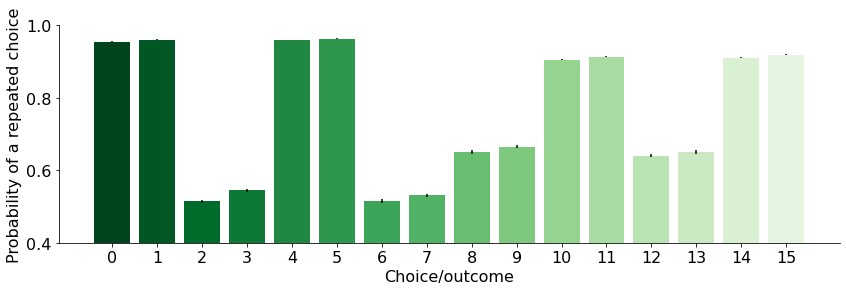

In [134]:
# Plot
fig, ax = plt.subplots(figsize=(14,4))
ax.bar(np.arange(16), means, color=colors)
ax.errorbar(np.arange(16), means,yerr=sems,linestyle='None',color='black')
ax.set_xticks(np.arange(16))
ax.set_ylim([0.4,1])
ax.set_yticks([0.4, 0.6, 0.8, 1])
ax.set_ylabel('Probability of a repeated choice')
ax.set_xlabel('Choice/outcome')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('RL_tree.png', format='png', dpi=1000,bbox_inches = 'tight')

In [136]:
# Test for significance (stay vs. shift with same outcomes and initial choice)
print(st.ttest_ind(rl_vals[0], rl_vals[2]))
print(st.ttest_ind(rl_vals[1], rl_vals[3]))
print(st.ttest_ind(rl_vals[4], rl_vals[6]))
print(st.ttest_ind(rl_vals[5], rl_vals[7]))
print(st.ttest_ind(rl_vals[8], rl_vals[10]))
print(st.ttest_ind(rl_vals[9], rl_vals[11]))
print(st.ttest_ind(rl_vals[12], rl_vals[14]))
print(st.ttest_ind(rl_vals[13], rl_vals[15]))

Ttest_indResult(statistic=167.04874605120824, pvalue=0.0)
Ttest_indResult(statistic=174.54838356407782, pvalue=0.0)
Ttest_indResult(statistic=177.53701516486132, pvalue=0.0)
Ttest_indResult(statistic=195.3937987253784, pvalue=0.0)
Ttest_indResult(statistic=-66.25718800933525, pvalue=0.0)
Ttest_indResult(statistic=-71.14263478176929, pvalue=0.0)
Ttest_indResult(statistic=-75.33573804555435, pvalue=0.0)
Ttest_indResult(statistic=-82.86639054021583, pvalue=0.0)


In [135]:
# Test for significance (loss vs. win on last game)
print(st.ttest_ind(rl_vals[0], rl_vals[1]))
print(st.ttest_ind(rl_vals[2], rl_vals[3]))
print(st.ttest_ind(rl_vals[4], rl_vals[5]))
print(st.ttest_ind(rl_vals[6], rl_vals[7]))
print(st.ttest_ind(rl_vals[8], rl_vals[9]))
print(st.ttest_ind(rl_vals[10], rl_vals[11]))
print(st.ttest_ind(rl_vals[12], rl_vals[13]))
print(st.ttest_ind(rl_vals[14], rl_vals[15]))

Ttest_indResult(statistic=-7.529346138360885, pvalue=5.115260946834038e-14)
Ttest_indResult(statistic=-4.116705689256769, pvalue=3.8602825228098516e-05)
Ttest_indResult(statistic=-5.9103014930706435, pvalue=3.4183073750933725e-09)
Ttest_indResult(statistic=-2.115101603129527, pvalue=0.03443445896595686)
Ttest_indResult(statistic=-2.132991506034667, pvalue=0.032938535518895)
Ttest_indResult(statistic=-4.660190271350818, pvalue=3.16310371760835e-06)
Ttest_indResult(statistic=-1.462640295481577, pvalue=0.1435817667950536)
Ttest_indResult(statistic=-4.884402837023403, pvalue=1.0387280249029715e-06)


In [137]:
# Create an array with the outcomes of the previous games
X = np.array([[0.5 if iprev==-1 else 
               (df_binary['result'][iprev] if df_binary['fifthcode'][iprev]=='R' else 1-df_binary['result'][iprev]) 
               for iprev in df_binary['white_game_' + str(n) + '_back']] for n in range(1,31)])

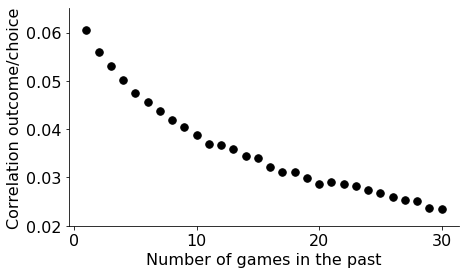

In [138]:
# Plot the correlation between outcome of previous games and choice in current game
fig, ax = plt.subplots(figsize=(7,4))

ax.plot(range(1,31),[np.corrcoef(X[n,:],df_binary['fifthcode']=='R')[0,1] for n in range(30)],'.',markersize=15, color='black')
ax.set_xlabel('Number of games in the past')
ax.set_ylabel('Correlation outcome/choice')
ax.set_yticks([.02, .03, .04, .05, .06])
ax.set_xticks([0,10,20,30])
ax.set_ylim([.02,.065])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('RL_corr.png', format='png', dpi=1000,bbox_inches = 'tight')

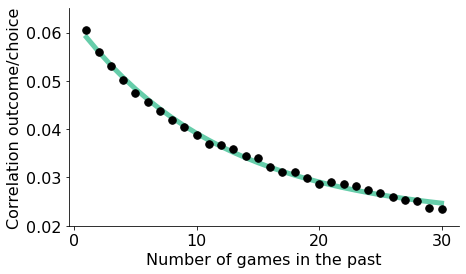

In [139]:
# Same plot with an exponential fit
popt, pcov = curve_fit(exp_func, range(1,31), [np.corrcoef(X[n,:],df_binary['fifthcode']=='R')[0,1] for n in range(30)])

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(range(1,31), exp_func(range(1,31), *popt), lw=5, color='mediumaquamarine')
ax.plot(range(1,31),[np.corrcoef(X[n,:],df_binary['fifthcode']=='R')[0,1] for n in range(30)],'.',markersize=15, color='black')
ax.set_xlabel('Number of games in the past')
ax.set_ylabel('Correlation outcome/choice')
ax.set_yticks([.02, .03, .04, .05, .06])
ax.set_xticks([0,10,20,30])
ax.set_ylim([.02,.065])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('RL_corr.png', format='png', dpi=1000,bbox_inches = 'tight')

In [140]:
# Compute the mean and sem binned for response time vs. probability of ruy lopez
all_rt = df_binary.loc[df_binary['rt'] >= 0]['rt'].values
all_codes = df_binary.loc[df_binary['rt'] >= 0]['fifthcode'].values
all_codes_binary = np.where(all_codes == 'R', 1, 0)

bin_means, bin_edges, binnumber = binned_statistic(all_rt, all_codes_binary, statistic='mean', bins=10, range=(0, 10))
bin_sem, bin_edges_sem, binnumber_sem = binned_statistic(all_rt, all_codes_binary, statistic=stats.sem, bins=10, range=(0, 10))

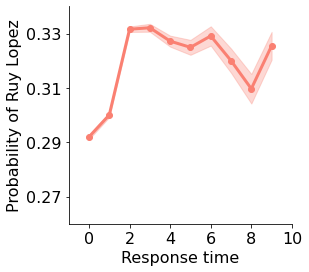

In [141]:
# Plot
fig, ax = plt.subplots(figsize=(4,4))

ax.errorbar(bin_edges[:-1], bin_means, marker='o', color='salmon', lw=3)
ax.fill_between(bin_edges[:-1], bin_means-bin_sem, bin_means+bin_sem, color='salmon', alpha=0.3)
ax.set_ylabel('Probability of Ruy Lopez')
ax.set_xlabel('Response time')
ax.set_xlim(-1, 10)
ax.set_ylim(0.26,0.34)
ax.set_xticks([0, 2, 4, 6, 8, 10])
ax.set_yticks([0.27, 0.29, 0.31, 0.33])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('rt_ruylopez.png', format='png', dpi=1000,bbox_inches = 'tight')

In [142]:
# Compute the mean and sem binned for elo vs. probability of ruy lopez
all_elo = df_binary.loc[df_binary['whiteelo'] >= 0]['whiteelo'].values
all_codes = df_binary.loc[df_binary['whiteelo'] >= 0]['fifthcode'].values
all_codes_binary = np.where(all_codes == 'R', 1, 0)

bin_means, bin_edges, binnumber = binned_statistic(all_elo, all_codes_binary, statistic='mean', bins=10, range=(800, 1200))
bin_sem, bin_edges_sem, binnumber_sem = binned_statistic(all_elo, all_codes_binary, statistic=stats.sem, bins=10, range=(800, 1200))

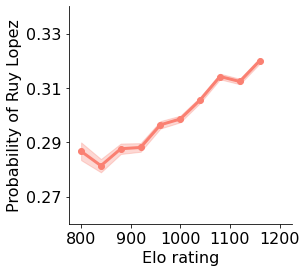

In [143]:
# Plot
fig, ax = plt.subplots(figsize=(4,4))

ax.errorbar(bin_edges[:-1], bin_means, marker='o', color='salmon', lw=3)
ax.fill_between(bin_edges[:-1], bin_means-bin_sem, bin_means+bin_sem, color='salmon', alpha=0.3)
ax.set_ylabel('Probability of Ruy Lopez')
ax.set_xlabel('Elo rating')
ax.set_xlim(775, 1225)
ax.set_ylim(0.26,0.34)
ax.set_xticks([800, 900, 1000, 1100, 1200])
ax.set_yticks([0.27, 0.29, 0.31, 0.33])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('elo_ruylopez.png', format='png', dpi=1000,bbox_inches = 'tight')

In [144]:
# Compute the correlation between player and opponent elo
print(df_binary['blackelo'].corr(df_binary['whiteelo']))

0.7849016540439494


Text(0, 0.5, 'Number of games')

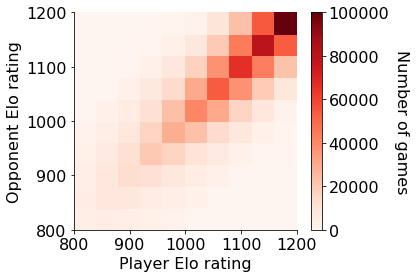

In [145]:
player_elo = df_binary['blackelo'].values
opp_elo = df_binary['whiteelo'].values

# Plot
fig, ax = plt.subplots(figsize=(5,4))

counts, xedges, yedges, im = ax.hist2d(player_elo, opp_elo, cmap=plt.cm.Reds, vmin=0, vmax=100000)
ax.set_ylabel('Opponent Elo rating')
ax.set_xlabel('Player Elo rating')
ax.set_xticks([800, 900, 1000, 1100, 1200])
ax.set_yticks([800, 900, 1000, 1100, 1200])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Number of games', rotation=-90, labelpad=20)

# plt.savefig('elo_corr.png', format='png', dpi=1000,bbox_inches = 'tight')

## Caro-Kann Defense

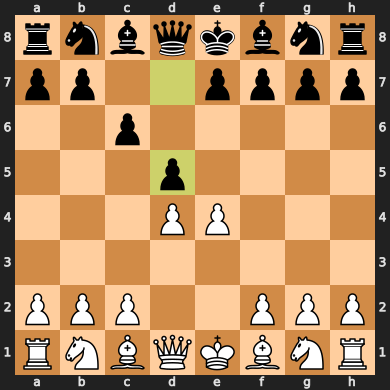

In [8]:
# Visualize the Caro-Kann Defense
board = chess.Board()
board.push_san('e4')
board.push_san('c6')
board.push_san('d4')
board.push_san('d5')
board

In [7]:
# Save out the board image
boardsvg = chess.svg.board(board)
outputfile = open('caro_kann.svg', "w")
outputfile.write(boardsvg)
outputfile.close()

In [147]:
# Load the csv data of CK games (October 2020 - March 2021)
direc = '../../Data/caro_kann/'

df = pd.concat([pd.read_csv(direc + 'df_{:d}_{:02d}.csv'.format(2020 + j//12,j%12+1),
                            usecols=['white','black','start_time','fifthmove','rt','result', 'blackelo', 'whiteelo',
                                     'num_black_games','num_white_games'])
                for j in range(9,15)],ignore_index=True)

In [148]:
# Load the pkl data of unique players (March 2020 - September 2020)
players = []
direc = '../../Data/caro_kann/'
for i in range(3,9):
    with open(direc + 'CK_players_2020_{:02d}.pkl'.format(i),'rb') as f:
        players = pickle.load(f)
s = set(np.array(players).flatten())

# Filter out players who have played the CK in this period
df = df[df['white'].apply(lambda p: not p in s)].reset_index(drop=True)

In [149]:
# Add advance, exchange, or other to df
df['fifthcode'] = df['fifthmove'].map({'e4e5' : 'A', 'e4d5' : 'E'}).fillna('O')

# Add move index to df
unique_fifthmoves,_ = get_ordered_unique_values(df['fifthmove'].astype(str))
move_to_index = {m:i for i,m in enumerate(unique_fifthmoves)}
df['fifthindex'] = np.array([move_to_index[m] for m in df['fifthmove'].astype(str)])

In [150]:
move_to_index

{'e4e5': 0,
 'e4d5': 1,
 'b1c3': 2,
 'f2f3': 3,
 'g1f3': 4,
 'f1d3': 5,
 'c2c3': 6,
 'c2c4': 7,
 'b1d2': 8,
 'c1f4': 9,
 'd1f3': 10,
 'f2f4': 11,
 'c1e3': 12,
 'd1e2': 13,
 'd1h5': 14,
 'd1d3': 15,
 'nan': 16,
 'c1g5': 17,
 'g1e2': 18,
 'b2b3': 19,
 'c1d2': 20,
 'f1c4': 21,
 'g2g3': 22,
 'g1h3': 23,
 'f1e2': 24,
 'd1g4': 25,
 'h2h3': 26,
 'b2b4': 27,
 'a2a4': 28,
 'b1a3': 29,
 'h2h4': 30,
 'e1e2': 31,
 'a2a3': 32,
 'd1d2': 33,
 'f1b5': 34,
 'f1a6': 35,
 'g2g4': 36}

In [151]:
# View the remaining data
df

,black,white,start_time,fifthmove,rt,result,blackelo,whiteelo,num_black_games,num_white_games,fifthcode,fifthindex
0,xhessfolife,math_floor,1.601536e+09,e4e5,2.0,0.0,1098,1137,0,0,A,0
1,SrGordito,ridwani,1.601536e+09,b1c3,-1.0,1.0,1031,1043,0,0,O,2
2,simplex2185,Eweheg,1.601536e+09,e4d5,3.0,0.0,855,880,0,0,E,1
3,wilsonericn,apriori96,1.601537e+09,e4e5,0.0,1.0,1123,1113,0,0,A,0
4,prowessjen,gop2cob,1.601537e+09,e4d5,2.0,1.0,1079,1170,0,0,E,1
...,...,...,...,...,...,...,...,...,...,...,...,...
117420,SrPinguin,tobezors,1.617259e+09,b1c3,1.0,0.0,1141,1168,0,0,O,2
117421,EvDawg74,Arkadaslarimiz,1.617260e+09,e4e5,3.0,0.0,1176,1198,7,0,A,0
117422,ojor_the_ancient,ThomasRiordan,1.617260e+09,e4d5,0.0,0.0,1094,1087,70,8,E,1
117423,javlaF,orthojb,1.617260e+09,e4e5,3.0,0.0,1083,1069,0,0,A,0


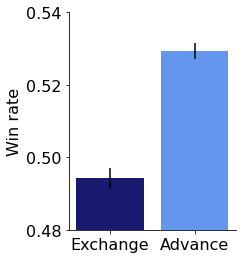

In [152]:
# Plot the overall win rate for advance/exchange CK
fig, ax = plt.subplots(figsize=(3,4))

df_by_code = df[df['fifthcode'].isin(['A','E'])].groupby('fifthcode')['result'].agg(['mean','sem']).reset_index()
ax.bar(range(len(df_by_code)),df_by_code['mean'].sort_values(), color=['midnightblue', 'cornflowerblue'])
ax.errorbar(x=range(len(df_by_code)),y=df_by_code['mean'].sort_values(),yerr=[df_by_code['sem'][1],df_by_code['sem'][0]],linestyle='None',color='black')
ax.set_xticks(range(len(df_by_code)))
ax.set_xticklabels(['Exchange', 'Advance'])
ax.set_yticks([0.48, 0.5, 0.52, 0.54])
ax.set_ylim([0.48,0.54])
ax.set_ylabel('Win rate')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('winrate.png', format='png', dpi=1000,bbox_inches = 'tight')

In [153]:
# Test for significance
exchange = [df['result'][icurr] for icurr in range(len(df)) if df['fifthcode'][icurr]=='E']
advance = [df['result'][icurr] for icurr in range(len(df)) if df['fifthcode'][icurr]=='A']
exchange = np.asarray(exchange)
advance = np.asarray(advance)
exhange = exchange[~np.isnan(exchange)]
advance = advance[~np.isnan(advance)]

print(st.ttest_ind(exchange, advance))

Ttest_indResult(statistic=-9.648737250531195, pvalue=5.1182514357428685e-22)


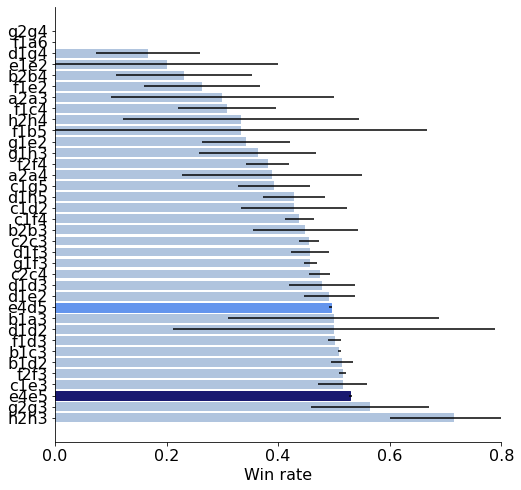

In [154]:
# Plot the win rate for different responses to the CK
fig, ax = plt.subplots(figsize=(8,8))

df_by_move = df.groupby('fifthmove')['result'].agg(['mean','sem']).sort_values('mean').reset_index()
barlist = ax.barh(range(len(df_by_move)),df_by_move['mean'], color='lightsteelblue')
ax.errorbar(y=range(len(df_by_move)),x=df_by_move['mean'],xerr=df_by_move['sem'],linestyle='None',color='black')
ax.set_yticks(range(len(df_by_move)))
ax.set_yticklabels(labels=df_by_move['fifthmove'])
ax.set_xlabel('Win rate')
ax.set_xlim(0,.8)
ax.set_xticks([0,0.2,0.4, 0.6, 0.8])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

barlist[33].set_color('midnightblue')
barlist[25].set_color('cornflowerblue')
plt.gca().invert_yaxis()

# plt.savefig('responses_winrate.png', format='png', dpi=1000,bbox_inches = 'tight')

In [155]:
# Create a binary dataframe of just advance/exchange
df_binary = df[(df['fifthcode'].isin(['A','E'])) & (~df['result'].isna())].reset_index(drop=True)
names,ind = np.unique(df_binary['white'],return_inverse=True)
name_to_ind = dict(zip(names,ind))

df_binary

,black,white,start_time,fifthmove,rt,result,blackelo,whiteelo,num_black_games,num_white_games,fifthcode,fifthindex
0,xhessfolife,math_floor,1.601536e+09,e4e5,2.0,0.0,1098,1137,0,0,A,0
1,simplex2185,Eweheg,1.601536e+09,e4d5,3.0,0.0,855,880,0,0,E,1
2,wilsonericn,apriori96,1.601537e+09,e4e5,0.0,1.0,1123,1113,0,0,A,0
3,prowessjen,gop2cob,1.601537e+09,e4d5,2.0,1.0,1079,1170,0,0,E,1
4,RErwin,MoinZenMeister,1.601541e+09,e4d5,2.0,0.0,1162,1052,0,0,E,1
...,...,...,...,...,...,...,...,...,...,...,...,...
78718,EvDawg74,Katers100,1.617259e+09,e4d5,2.0,0.0,1144,1161,6,0,E,1
78719,EvDawg74,Arkadaslarimiz,1.617260e+09,e4e5,3.0,0.0,1176,1198,7,0,A,0
78720,ojor_the_ancient,ThomasRiordan,1.617260e+09,e4d5,0.0,0.0,1094,1087,70,8,E,1
78721,javlaF,orthojb,1.617260e+09,e4e5,3.0,0.0,1083,1069,0,0,A,0


In [156]:
# Compute the number of unique players that played the opening
len(np.unique(df_binary['white']))

39825

In [157]:
# Compute the percentage of moves that reduction contains
len(df_binary)/len(df)

0.670410900574835

In [158]:
# Compute the index of the last game as black/white for each CK game
last_game_as_white = [None]*len(df_binary)
last_game_as_black = [None]*len(df_binary)

d_black = defaultdict(lambda: -1)
d_white = defaultdict(lambda: -1)

for i,row in df_binary.iterrows():
    
    last_game_as_white[i] = d_white[row['white']]
    last_game_as_black[i] = d_black[row['white']]
    d_white[row['white']] = i
    d_black[row['black']] = i
    
    if i%100000==0:
        print(i)

0


In [159]:
# Add these to the dataframe
df_binary['last_game_as_white'] = last_game_as_white
df_binary['last_game_as_black'] = last_game_as_black

df_binary

,black,white,start_time,fifthmove,rt,result,blackelo,whiteelo,num_black_games,num_white_games,fifthcode,fifthindex,last_game_as_white,last_game_as_black
0,xhessfolife,math_floor,1.601536e+09,e4e5,2.0,0.0,1098,1137,0,0,A,0,-1,-1
1,simplex2185,Eweheg,1.601536e+09,e4d5,3.0,0.0,855,880,0,0,E,1,-1,-1
2,wilsonericn,apriori96,1.601537e+09,e4e5,0.0,1.0,1123,1113,0,0,A,0,-1,-1
3,prowessjen,gop2cob,1.601537e+09,e4d5,2.0,1.0,1079,1170,0,0,E,1,-1,-1
4,RErwin,MoinZenMeister,1.601541e+09,e4d5,2.0,0.0,1162,1052,0,0,E,1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78718,EvDawg74,Katers100,1.617259e+09,e4d5,2.0,0.0,1144,1161,6,0,E,1,73592,-1
78719,EvDawg74,Arkadaslarimiz,1.617260e+09,e4e5,3.0,0.0,1176,1198,7,0,A,0,-1,-1
78720,ojor_the_ancient,ThomasRiordan,1.617260e+09,e4d5,0.0,0.0,1094,1087,70,8,E,1,69007,-1
78721,javlaF,orthojb,1.617260e+09,e4e5,3.0,0.0,1083,1069,0,0,A,0,76586,-1


In [160]:
# Compute the win-stay, lose-shift mean and sem for the CK
result = df_binary['result'].values
code = df_binary['fifthcode'].values

means = [get_mean_and_sem([code[icurr]==code[iprev] for icurr,iprev in enumerate(df_binary['last_game_as_white']) 
                           if iprev>=0 and result[iprev]==res]) for res in [0,0.5,1]]

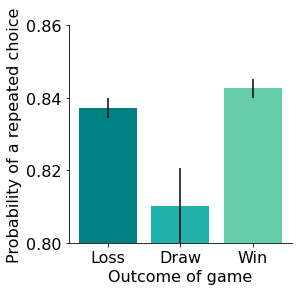

In [161]:
# Plot the win-stay, lose-shift probabilities for the CK
fig, ax = plt.subplots(figsize=(4,4))
colors = ['teal', 'lightseagreen', 'mediumaquamarine']

x = [1,2,3]
ax.bar(x,[m for m,s in means], color=[c for c in colors])
ax.errorbar(x,y=[m for m,s in means],yerr=[s for m,s in means],linestyle='None',color='black')
ax.set_xticks(x)
ax.set_xticklabels(['Loss','Draw','Win'])
ax.set_yticks([.8, .82, 0.84, 0.86])
ax.set_ylim([0.8,0.86])
ax.set_ylabel('Probability of a repeated choice')
ax.set_xlabel('Outcome of game')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('RL_repeat.png', format='png', dpi=1000,bbox_inches = 'tight')

In [162]:
# Test for significance
loss = [code[icurr]==code[iprev] for icurr,iprev in enumerate(df_binary['last_game_as_white']) 
                           if iprev>=0 and result[iprev]==0]
win = [code[icurr]==code[iprev] for icurr,iprev in enumerate(df_binary['last_game_as_white']) 
                           if iprev>=0 and result[iprev]==1]

print(st.ttest_ind(loss, win))

Ttest_indResult(statistic=-1.4308906544713917, pvalue=0.1524698838050694)


In [163]:
# Repeat for the opponent's move
result = df_binary['result'].values
code = df_binary['fifthcode'].values

means = [get_mean_and_sem([code[icurr]==code[iprev] for icurr,iprev in enumerate(df_binary['last_game_as_black']) 
                           if iprev>=0 and result[iprev]==res]) for res in [1,0.5,0]]

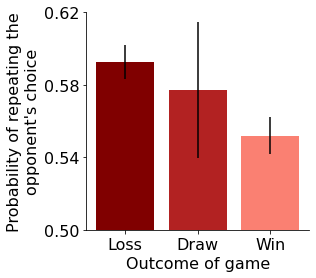

In [164]:
# Plot the win-stay, lose-shift probabilities for the SD
fig, ax = plt.subplots(figsize=(4,4))
colors = ['maroon', 'firebrick', 'salmon']

x = [1,2,3]
ax.bar(x,[m for m,s in means], color=[c for c in colors])
ax.errorbar(x,y=[m for m,s in means],yerr=[s for m,s in means],linestyle='None',color='black')
ax.set_xticks(x)
ax.set_xticklabels(['Loss','Draw','Win'])
ax.set_yticks([0.5, 0.54, 0.58, 0.62])
ax.set_ylim([0.5,0.62])
ax.set_ylabel('Probability of repeating the\nopponent\'s choice')
ax.set_xlabel('Outcome of game')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('opp_RL_repeat.png', format='png', dpi=1000,bbox_inches = 'tight')

In [165]:
# Test for significance
loss = [code[icurr]==code[iprev] for icurr,iprev in enumerate(df_binary['last_game_as_black']) 
                           if iprev>=0 and result[iprev]==1]
win = [code[icurr]==code[iprev] for icurr,iprev in enumerate(df_binary['last_game_as_black']) 
                           if iprev>=0 and result[iprev]==0]

print(st.ttest_ind(loss, win))

Ttest_indResult(statistic=2.949509929990906, pvalue=0.0031970383995923767)


In [166]:
# Repeat for copy effect
result = df_binary['result'].values
code = df_binary['fifthcode'].values

means = [get_mean_and_sem([code[icurr]=='A' for icurr,iprev in enumerate(df_binary['last_game_as_black']) 
                           if iprev>=0 and code[iprev]==opp_code]) for opp_code in ['A','E']]

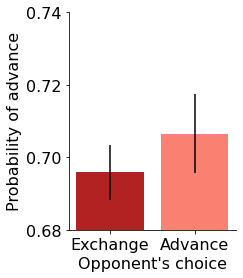

In [167]:
# Plot
fig, ax = plt.subplots(figsize=(3,4))
colors = ['firebrick', 'salmon']

x = [1,2]
ax.bar(x,[means[1][0], means[0][0]], color=[c for c in colors])
ax.errorbar(x,y=[means[1][0], means[0][0]],yerr=[means[0][1], means[1][1]],linestyle='None',color='black')
ax.set_xticks(x)
ax.set_xticklabels(['Exchange','Advance'])
ax.set_yticks([0.68, 0.7, 0.72, 0.74])
ax.set_ylim([0.68,0.74])
ax.set_ylabel('Probability of advance')
ax.set_xlabel('Opponent\'s choice')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('opp_copy.png', format='png', dpi=1000,bbox_inches = 'tight')

In [168]:
# Test for significance
accept = [code[icurr]=='A' for icurr,iprev in enumerate(df_binary['last_game_as_black']) 
                           if iprev>=0 and code[iprev]=='A']
decline = [code[icurr]=='A' for icurr,iprev in enumerate(df_binary['last_game_as_black']) 
                           if iprev>=0 and code[iprev]=='E']

print(st.ttest_ind(accept, decline))

Ttest_indResult(statistic=0.799512423804825, pvalue=0.42402884727412293)


In [169]:
# Compute the index of the nth CK game back as white
nback = last_game_as_white
for n in range(1,31):
    df_binary['white_game_' + str(n) + '_back'] = nback
    nback = [last_game_as_white[i] if i>=0 else -1 for i in nback]

In [170]:
df_binary

,black,white,start_time,fifthmove,rt,result,blackelo,whiteelo,num_black_games,num_white_games,...,white_game_21_back,white_game_22_back,white_game_23_back,white_game_24_back,white_game_25_back,white_game_26_back,white_game_27_back,white_game_28_back,white_game_29_back,white_game_30_back
0,xhessfolife,math_floor,1.601536e+09,e4e5,2.0,0.0,1098,1137,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,simplex2185,Eweheg,1.601536e+09,e4d5,3.0,0.0,855,880,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,wilsonericn,apriori96,1.601537e+09,e4e5,0.0,1.0,1123,1113,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,prowessjen,gop2cob,1.601537e+09,e4d5,2.0,1.0,1079,1170,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,RErwin,MoinZenMeister,1.601541e+09,e4d5,2.0,0.0,1162,1052,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78718,EvDawg74,Katers100,1.617259e+09,e4d5,2.0,0.0,1144,1161,6,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
78719,EvDawg74,Arkadaslarimiz,1.617260e+09,e4e5,3.0,0.0,1176,1198,7,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
78720,ojor_the_ancient,ThomasRiordan,1.617260e+09,e4d5,0.0,0.0,1094,1087,70,8,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
78721,javlaF,orthojb,1.617260e+09,e4e5,3.0,0.0,1083,1069,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [171]:
# Compute the win-stay, lose-shift mean and sem for the CK 2 games back
rl_probs = np.zeros((4,4))
rl_count = np.zeros((4,4))
rl_vals = [[] for x in range(16)]

result = df_binary['result'].values
code = df_binary['fifthcode'].values

# Loop through the dataframe
for ind in df_binary.index:
    
    # Grab the previous 2 indices, results, and codes as black
    res = df_binary['result'][ind]
    iprev1 = df_binary['white_game_1_back'][ind]
    iprev2 = df_binary['white_game_2_back'][ind]
    res1 = result[iprev1]
    res2 = result[iprev2]
    code1 = code[iprev1]
    code2 = code[iprev2]
    
    # If there is a 2 game history
    if iprev1 >= 0 and iprev2 >= 0:
        
        # Check if there was a repetition
        if code[ind] == code1:
            repeat = 1
        else:
            repeat = 0
        
        # Assign it to the correct part of the array
        if code2 == 'E' and res2 == 0 and code1 == 'E' and res1 == 0:
            rl_vals[0].append(repeat)
        elif code2 == 'E' and res2 == 0 and code1 == 'E' and res1 == 1:
            rl_vals[1].append(repeat)
        elif code2 == 'E' and res2 == 0 and code1 == 'A' and res1 == 0:
            rl_vals[2].append(repeat)
        elif code2 == 'E' and res2 == 0 and code1 == 'A' and res1 == 1:
            rl_vals[3].append(repeat)
            
        elif code2 == 'E' and res2 == 1 and code1 == 'E' and res1 == 0:
            rl_vals[4].append(repeat)
        elif code2 == 'E' and res2 == 1 and code1 == 'E' and res1 == 1:
            rl_vals[5].append(repeat)
        elif code2 == 'E' and res2 == 1 and code1 == 'A' and res1 == 0:
            rl_vals[6].append(repeat)
        elif code2 == 'E' and res2 == 1 and code1 == 'A' and res1 == 1:
            rl_vals[7].append(repeat)
            
        elif code2 == 'A' and res2 == 0 and code1 == 'E' and res1 == 0:
            rl_vals[8].append(repeat)
        elif code2 == 'A' and res2 == 0 and code1 == 'E' and res1 == 1:
            rl_vals[9].append(repeat)
        elif code2 == 'A' and res2 == 0 and code1 == 'A' and res1 == 0:
            rl_vals[10].append(repeat)
        elif code2 == 'A' and res2 == 0 and code1 == 'A' and res1 == 1:
            rl_vals[11].append(repeat)
            
        elif code2 == 'A' and res2 == 1 and code1 == 'E' and res1 == 0:
            rl_vals[12].append(repeat)
        elif code2 == 'A' and res2 == 1 and code1 == 'E' and res1 == 1:
            rl_vals[13].append(repeat)
        elif code2 == 'A' and res2 == 1 and code1 == 'A' and res1 == 0:
            rl_vals[14].append(repeat)
        elif code2 == 'A' and res2 == 1 and code1 == 'A' and res1 == 1:
            rl_vals[15].append(repeat)


In [172]:
# Compute all combinations of the probabilities
means = []
sems = []

for i in range(16):
    means.append(np.mean(rl_vals[i]))
    sems.append(stats.sem(rl_vals[i]))
    
means

[0.8467317806160781,
 0.8307692307692308,
 0.6355140186915887,
 0.6666666666666666,
 0.824124513618677,
 0.8620961386918834,
 0.5875576036866359,
 0.6972477064220184,
 0.4534313725490196,
 0.49382716049382713,
 0.9291641967990516,
 0.9329911605360707,
 0.48009950248756217,
 0.5023809523809524,
 0.9288571428571428,
 0.9292903225806451]

In [173]:
# Generate a colormap
data = [i for i in range(18)]
denominator = max(data) - min(data)
scaled_data = [(datum-min(data))/denominator for datum in data]
colors = []
cmap = plt.cm.get_cmap('Greens_r')
for decimal in scaled_data:
    colors.append(cmap(decimal))

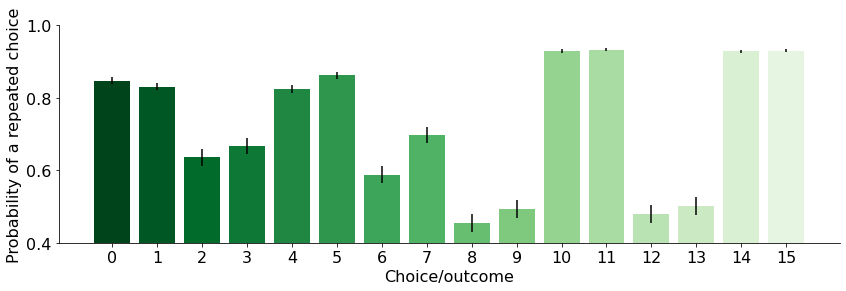

In [174]:
# Plot
fig, ax = plt.subplots(figsize=(14,4))
ax.bar(np.arange(16), means, color=colors)
ax.errorbar(np.arange(16), means,yerr=sems,linestyle='None',color='black')
ax.set_xticks(np.arange(16))
ax.set_ylim([0.4,1])
ax.set_yticks([0.4, 0.6, 0.8, 1])
ax.set_ylabel('Probability of a repeated choice')
ax.set_xlabel('Choice/outcome')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('RL_tree.png', format='png', dpi=1000,bbox_inches = 'tight')

In [176]:
# Test for significance (stay vs. shift with same outcomes and initial choice)
print(st.ttest_ind(rl_vals[0], rl_vals[2]))
print(st.ttest_ind(rl_vals[1], rl_vals[3]))
print(st.ttest_ind(rl_vals[4], rl_vals[6]))
print(st.ttest_ind(rl_vals[5], rl_vals[7]))
print(st.ttest_ind(rl_vals[8], rl_vals[10]))
print(st.ttest_ind(rl_vals[9], rl_vals[11]))
print(st.ttest_ind(rl_vals[12], rl_vals[14]))
print(st.ttest_ind(rl_vals[13], rl_vals[15]))

Ttest_indResult(statistic=9.6629758581212, pvalue=1.4729049855520537e-21)
Ttest_indResult(statistic=7.443694676353433, pvalue=1.529756140908701e-13)
Ttest_indResult(statistic=10.342708121591237, pvalue=2.305064509626642e-24)
Ttest_indResult(statistic=7.862978782406947, pvalue=6.603874504671005e-15)
Ttest_indResult(statistic=-31.040233748170184, pvalue=1.2361885325356299e-188)
Ttest_indResult(statistic=-29.228433569794376, pvalue=4.961280942322957e-170)
Ttest_indResult(statistic=-29.222888574439636, pvalue=6.2133371123976025e-170)
Ttest_indResult(statistic=-28.71251367626673, pvalue=5.3298012111005213e-166)


In [175]:
# Test for significance (loss vs. win on last game)
print(st.ttest_ind(rl_vals[0], rl_vals[1]))
print(st.ttest_ind(rl_vals[2], rl_vals[3]))
print(st.ttest_ind(rl_vals[4], rl_vals[5]))
print(st.ttest_ind(rl_vals[6], rl_vals[7]))
print(st.ttest_ind(rl_vals[8], rl_vals[9]))
print(st.ttest_ind(rl_vals[10], rl_vals[11]))
print(st.ttest_ind(rl_vals[12], rl_vals[13]))
print(st.ttest_ind(rl_vals[14], rl_vals[15]))

Ttest_indResult(statistic=1.1132084678340337, pvalue=0.26572067806588456)
Ttest_indResult(statistic=-0.966100757588017, pvalue=0.3342613142219153)
Ttest_indResult(statistic=-2.6398536781484605, pvalue=0.00834468139919976)
Ttest_indResult(statistic=-3.393843905616945, pvalue=0.0007204082677769335)
Ttest_indResult(statistic=-1.1529420528841179, pvalue=0.24927386987429553)
Ttest_indResult(statistic=-0.6265464627468477, pvalue=0.5309773620539675)
Ttest_indResult(statistic=-0.6381415665428877, pvalue=0.5235596966987455)
Ttest_indResult(statistic=-0.07236036434480915, pvalue=0.9423170894715021)


In [177]:
# Create an array with the outcomes of the previous games
X = np.array([[0.5 if iprev==-1 else 
               (df_binary['result'][iprev] if df_binary['fifthcode'][iprev]=='A' else 1-df_binary['result'][iprev]) 
               for iprev in df_binary['white_game_' + str(n) + '_back']] for n in range(1,31)])

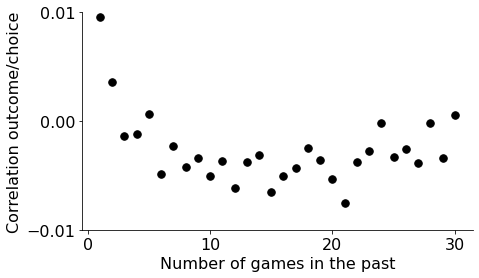

In [178]:
# Plot the correlation between outcome of previous games and choice in current game
fig, ax = plt.subplots(figsize=(7,4))

ax.plot(range(1,31),[np.corrcoef(X[n,:],df_binary['fifthcode']=='A')[0,1] for n in range(30)],'.',markersize=15, color='black')
ax.set_xlabel('Number of games in the past')
ax.set_ylabel('Correlation outcome/choice')
ax.set_xticks([0,10,20,30])
ax.set_ylim([-.01,0.01])
ax.set_yticks([-0.01,0,0.01])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('RL_corr.png', format='png', dpi=1000,bbox_inches = 'tight')

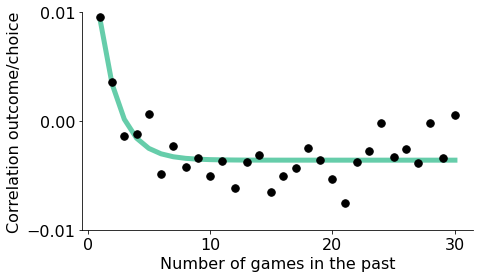

In [179]:
# Same plot with an exponential fit
popt, pcov = curve_fit(exp_func, range(1,31), [np.corrcoef(X[n,:],df_binary['fifthcode']=='A')[0,1] for n in range(30)])

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(range(1,31), exp_func(range(1,31), *popt), lw=5, color='mediumaquamarine')
ax.plot(range(1,31),[np.corrcoef(X[n,:],df_binary['fifthcode']=='A')[0,1] for n in range(30)],'.',markersize=15, color='black')
ax.set_xlabel('Number of games in the past')
ax.set_ylabel('Correlation outcome/choice')
ax.set_xticks([0,10,20,30])
ax.set_ylim([-.01,0.01])
ax.set_yticks([-0.01,0,0.01])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('RL_corr.png', format='png', dpi=1000,bbox_inches = 'tight')

In [180]:
# Compute the mean and sem binned for response time vs. probability of advance
all_rt = df_binary.loc[df_binary['rt'] >= 0]['rt'].values
all_codes = df_binary.loc[df_binary['rt'] >= 0]['fifthcode'].values
all_codes_binary = np.where(all_codes == 'A', 1, 0)

bin_means, bin_edges, binnumber = binned_statistic(all_rt, all_codes_binary, statistic='mean', bins=10, range=(0, 10))
bin_sem, bin_edges_sem, binnumber_sem = binned_statistic(all_rt, all_codes_binary, statistic=stats.sem, bins=10, range=(0, 10))

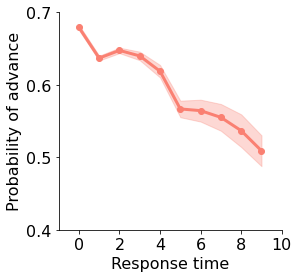

In [181]:
# Plot
fig, ax = plt.subplots(figsize=(4,4))

ax.errorbar(bin_edges[:-1], bin_means, marker='o', color='salmon', lw=3)
ax.fill_between(bin_edges[:-1], bin_means-bin_sem, bin_means+bin_sem, color='salmon', alpha=0.3)
ax.set_ylabel('Probability of advance')
ax.set_xlabel('Response time')
ax.set_xlim(-1, 10)
ax.set_ylim(0.4,0.7)
ax.set_xticks([0, 2, 4, 6, 8, 10])
ax.set_yticks([0.4, 0.5, 0.6, 0.7])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('rt_advance.png', format='png', dpi=1000,bbox_inches = 'tight')

In [182]:
# Compute the mean and sem binned for elo rating vs. probability of advance
all_elo = df_binary.loc[df_binary['whiteelo'] >= 0]['whiteelo'].values
all_codes = df_binary.loc[df_binary['whiteelo'] >= 0]['fifthcode'].values
all_codes_binary = np.where(all_codes == 'A', 1, 0)

bin_means, bin_edges, binnumber = binned_statistic(all_elo, all_codes_binary, statistic='mean', bins=10, range=(800, 1200))
bin_sem, bin_edges_sem, binnumber_sem = binned_statistic(all_elo, all_codes_binary, statistic=stats.sem, bins=10, range=(800, 1200))

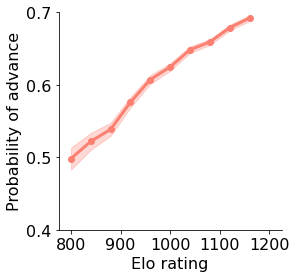

In [183]:
# Plot
fig, ax = plt.subplots(figsize=(4,4))

ax.errorbar(bin_edges[:-1], bin_means, marker='o', color='salmon', lw=3)
ax.fill_between(bin_edges[:-1], bin_means-bin_sem, bin_means+bin_sem, color='salmon', alpha=0.3)
ax.set_ylabel('Probability of advance')
ax.set_xlabel('Elo rating')
ax.set_xlim(775, 1225)
ax.set_ylim(0.4,0.7)
ax.set_xticks([800, 900, 1000, 1100, 1200])
ax.set_yticks([0.4, 0.5, 0.6, 0.7])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('elo_advance.png', format='png', dpi=1000,bbox_inches = 'tight')

In [185]:
# Compute the correlation between player and opponent elo
print(df_binary['blackelo'].corr(df_binary['whiteelo']))

0.7969392131364826


Text(0, 0.5, 'Number of games')

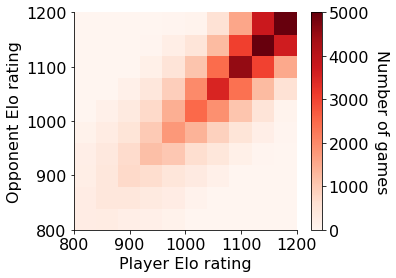

In [186]:
player_elo = df_binary['blackelo'].values
opp_elo = df_binary['whiteelo'].values

# Plot
fig, ax = plt.subplots(figsize=(5,4))

counts, xedges, yedges, im = ax.hist2d(player_elo, opp_elo, cmap=plt.cm.Reds, vmin=0, vmax=5000)
ax.set_ylabel('Opponent Elo rating')
ax.set_xlabel('Player Elo rating')
ax.set_xticks([800, 900, 1000, 1100, 1200])
ax.set_yticks([800, 900, 1000, 1100, 1200])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Number of games', rotation=-90, labelpad=20)

# plt.savefig('elo_corr.png', format='png', dpi=1000,bbox_inches = 'tight')